<a name="top">&nbsp;</a>
<h1>A Comprehensive Guide to the Total Order Sort <br>
design pattern in MapReduce</h1>
<h2>With Hadoop Streaming, MRJob, and Spark</h2>
<hr>
__by James G. Shanahan, Kyle Hamilton, Yiran Sheng__

University of California, Berkeley

__Email__: jimi@ischool.berkeley.edu, kylehamilton@ischool.berkeley.edu, yiran@ischool.berkeley.edu




In [7]:
from IPython.display import Image, HTML

In [8]:
with open("code-tab.css",'r') as style:
    code_tab_style = "<style>{}</style>".format(style.read())

HTML(code_tab_style)

<h1>Table of Contents</h1>
 <ul class="toc-item">
    <li><strong class="toc-heading"><a href="#Abstract">Abstract</a></strong></li>
    <li><strong class="toc-heading"><a href="#introduction">Introduction</a></strong></li>
    <li><strong class="toc-heading"><a href="#Terminology">Terminology</a></strong>
       <ul>
          <li><a href="#Hadoop">Hadoop</a></li>
          <li><a href="#Hadoop-Streaming">Hadoop Streaming</a></li>
          <li><a href="#MRJob">MRJob</a></li>
          <li><a href="#Partial-Sort">Partial Sort</a></li>
          <li><a href="#Total-Sort-(Unorderd-Partitions)">Total Sort (Unorderd Partitions)</a></li>
          <li><a href="#Total-Sort-(Ordered-Partitions)">Total Sort (Ordered Partitions)</a></li>
          <li><a href="#Secondary-Sorting">Secondary Sorting</a></li>
       </ul>
    </li>
    <li><strong class="toc-heading"><a href="#Examples-of-Different-Sort-Types-(in-context-of-Hadoop-and-HDFS)">Examples of Different Sort Types</a></strong></li>
    <li><strong class="toc-heading"><a href="#Anatomy-of-a-MapReduce-Job">Anatomy of a MapReduce Job</a></strong>   
    <li><strong class="toc-heading"><a href="#Prepare-Dataset">Prepare Dataset</a></strong>
    <li><strong class="toc-heading"><a href="#Section1">Section 1 - Understanding Linux Sort</a></strong>
        <ul>
            <li><a href="#importance-of-unix-sort">Importance of Unix Sort</a></li>
            <li><a href="#unix-sort-overview">Unix Sort Overview</a></li>
            <li><a href="#--sort-examples-">Sort Examples</a></li>
        </ul>
    </li>        
    <li><strong class="toc-heading"><a href="#Section2">Section 2 - Hadoop Streaming</a></strong>
        <ul>
            <li><a href="#II.A.-Hadoop's-Default-Sorting-Behavior">II.A. Hadoop's Default Sorting Behavior</a></li>
            <li><a href="#Hadoop-streaming-parameters">II.B. Hadoop Streaming parameters</a></li>
            <ol>
              <li><a href="#Configure-Hadoop-Streaming-0"> Configure Hadoop Streaming: Prerequisites</a></li>
              <li><a href="#Configure-Hadoop-Streaming-1"> Configure Hadoop Streaming: Step 1</a></li>
              <li><a href="#Configure-Hadoop-Streaming-2"> Configure Hadoop Streaming: Step 2</a></li>
              <li><a href="#Configure-Hadoop-Streaming-3">Configure Hadoop Streaming: Step 3</a></li>
              <li><a href="#Summary-of-Common-Practices">Summary of Common Practices of Sorting Related Configuration</a></li>
              <li><a href="#Side-by-side-Examples">Side-by-side Examples: unix sort vs. hadoop streaming</a></li>
            </ol>
            </li>
            <li>
              <a href="#Hadoop-streaming-implementation">II.C. Hadoop Streaming implementation</a>
              <ol>
                <li><a href="#single-reducer-hadoop-streaming">II.C.1. Hadoop Streaming Implementation - single reducer</a></li>
                <li><a href="#multiple-reducer-hadoop-streaming">II.C.2. Hadoop Streaming Implementation - multiple reducers</a>
                <ul>
                    <li><a href="#What's-new:-">What's New</a></li>
                    <li><a href="#Multiple-Reducer-Overview">Multiple Reducer Overview</a></li>
                    <li><a href="#Introductory-Example:">Introductory Example</a></li>
                    <li><a href="#Implementation-Walkthrough">Implementation Walkthrough</a></li>
                </ul>
                </li>
              </ol>
            </li>
        </ul>
   </li>
   <li><strong class="toc-heading"><a href="#Section3">Section 3 - MRJob</a></strong>
       <ul>
          <li><a href="#MRJob-modes">MRJob modes - Local, Hadoop, EMR</a></li>
          <li><a href="#MRJob-Protocols">MRJob Protocols</a>
              <ol>
                  <li><a href="#MRJob-Protocols-role">Types of Built-in Protocols</a></li>
                  <li><a href="#Importance-of-RawProtocols"> Importance of RawProtocols in Context of Total Sorting</a></li>
              </ol>
          </li>
          <li><a href="#MRJob-partitioning">Partitioning in MRJob</a></li>
          <li><a href="#illustration">Illustration</a></li>
          <li><a href="#MRJOB-implementation">MRJob implementation</a>
              <ol>
                <li><a href="#III.D.1">III.D.1 MRJob implementation - single reducer - local mode</a></li>
                <li><a href="#III.D.2">III.D.2. MRJob implementation - single reducer - hadoop mode</a></li>
                <li><a href="#III.D.3">III.D.3. MRJob Multiple Reducers - With Un-Ordered Partitons</a></li>
                <li><a href="#III.D.4">III.D.4. MRJob Multiple Reducers - With Ordered Partitons</a></li>
              </ol>
          </li>    
        </ul>
    </li>
    <li><strong class="toc-heading"><a href="#Section4">Section 4 - Sampling</a></strong>
        <ul>
            <li><a href="#randomsampling">Random Sampling</a></li>
            <li><a href="#reservoirsampling">Reservoir Sampling</a></li>
        </ul>
    </li>
    <li><strong class="toc-heading"><a href="#Section5">Section 5 - Spark</a></strong>
    </li>
    <li><strong class="toc-heading"><a href="#Final-Remarks">Final Remarks</a></strong></li>
    <li><strong class="toc-heading"><a href="#Reference">Reference</a></strong></li>
 </ul>


<h2><a name="Abstract">Abstract</a></h2>
<a href="#top">Back to top</a>

Sorting refers to arranging data in a particular format. A sorting algorithm specifies the way to arrange data in a particular order. Most common orders are numerical or lexicographical order. One important application of sorting lies in the fact that information search can be optimized to a very high level if data is stored in a sorted manner. Sorting is also used to represent data in more readable formats. Some of the examples of sorting in real life scenarios are the following.
* Telephone Directory – A telephone directory keeps telephone numbers of people sorted on their names so that names can be searched.
* Dictionary – A dictionary keeps words in alphabetical order so that searching of any word becomes easy.   

Sorting at scale can be accomplished via MapReduce frameworks such as Hadoop, Hadoop Streaming, MRJob and Spark all of which generally operate on data records consisting of key-value pairs. These frameworks, when run in default mode (by specifying either a mapper, a reducer, or both depending on what needs to be accomplished), will generate a partial order sort, whereby the reducer output will be a lot of (partition) files each of which contains key-value records that are sorted within each partition file based on the key. But there is no sort order between records in different partition files (see Figure 3). This is the default behavior for MapReduce frameworks such as Hadoop, Hadoop Streaming and MrJob; Spark works a little differently and will be discussed separately later. Sometimes it is desirable to have all data records sorted by a specified key (i.e., different to a partial order sort), across partition boundaries (see Figure 2). This can be accomplished relatively easily using these MapReduce frameworks. But to do so one needs to be familiar with some core concepts and design patterns. This paper introduces the building blocks for total sorting in the following MapReduce frameworks: Hadoop Streaming, MrJob, and Spark. Numerous complete working examples are also provided to demonstrate the key design patterns in total order sorts. Python is used as the language for driving all three MapReduce frameworks.   

<em>Keywords: total order sort at scale, sorting in Hadoop, MapReduce, Spark</em>


<h2><a name="introduction">INTRODUCTION</a></h2>
<a href="#top">Back to top</a>

In this notebook we are going to demonstrate how to achieve Total Order Sort via three MapReduce frameworks: Hadoop Streaming, MRJob, and Spark. Hadoop Streaming and MRJob borrow heavily in terms of syntax and semantics from the Unix sort and cut commands, whereby they treat the output of the mapper as series of records, where each record can be interpreted as a collection of fields/tokens that are tab delimited by default. In this way, fields can be specified for the purposes of partitioning (routing), sometimes referred to as the primary key. The primary key is used for partitioning, and the combination of the primary and secondary keys (also specified by the programmer) is used for sorting.   

We'll start by describing the Linux/Unix sort command (syntax and semantics) and build on that understanding to explain Total Order Sort in Hadoop Streaming and MRJob. Partitioning is not just matter of specifying the fields to be used for routing the records to the reducers. We also need to consider how best to partition the data that has skewed distributions. To that end, we'll demonstrate how to partition the data via sampling and assigning custom keys.   

Lastly, we'll provide a Spark version of Total Order Sort.   

At each step we are going to build on the previous steps, so it's important to view this notebook in order. For example, we'll cover key points for sorting with a single reducer in the Hadoop Streaming implementation, and these concepts will apply to the subsequent MRJob implementation.


<h1><a name="asdf">Anatomy of a MapReduce Job</a></h1>
<a href="#top">Back to top</a>

When tackling large scale data problems with modern computing frameworks such as MapReduce (Hadoop), one generally uses a divide-and-conquer strategy to divide these large problems into chunks of key-value records that can be processed by individual compute nodes (via mapper/reducer procedures). Upon importing the data into the Hadoop Distributed File System (HDFS), it is chunked in the following way: typically, there is a chunk for each input file. If the input file is too big (bigger than the HDFS block size) then we have two or more map chunks/splits associated to the same input file. (Please refer to the method getSplits() of the FileInputFormat class in Hadoop for more details.)   

Once the data has been uploaded to HDFS, MapReduce jobs can be run on the data. First we’ll focus on a basic MapReduce/Hadoop job. The programmer provides map and reduce functions and, subsequently, the Application Master will launch one MapTask for each map split/chunk.   


map(key1, value1) → list(key2, value2)

reduce(key2, list(value2)) → list(key3, value3)

First, the map() function receives a key-value pair input, (key1, value1). Then it outputs any number of key-value pairs, (key2, value2). Next, the reduce() function receives as input another key-value pair, (key2, list(value2)), and outputs any number of (key3, value3) pairs.   

Now consider the following key-value pair, (key2, list(value2)), as an input for a reducer:

list(value2) = (V1, V2, ..., Vn)

where there is no ordering between reducer values (V1, V2, ..., Vn).

The MapReduce framework performs the important tasks of routing, collating records with the same key, and transporting these records from the mapper to the reducer. These tasks are commonly referred to as the shuffle phase of a MapReduce job and are typically run in default mode (whereby the programmer does not customize the phase).   

So, for completeness, a typical MapReduce job consists of three phases (that are similar in style for all MapReduce frameworks):


__def MapReduceJob(Mapper, Shuffler, Reducer):__

* Mapper (programmer writes)
  * Mapper Init (setups a state for the mapper if required)
  * map(key1, value1) → list(key2, value2)
  * Mapper Final phase (tears down the map and outputs the mapper state to the stream if required)
 
* Shuffle Phase(Partitioner=Key, Sort=(Key, alphanumeric increasing), Combiner=None)
  * Where the default behaviors for the shuffle are as follows:
    * Partitioner=Key, 
    * Sort=(Key, alphanumeric increasing), 
    * Combiner=None 
  * Partitioner: specify key (or subset of fields) used for routing each record to the reducer
  * Sort specification: set of fields that make up the keys and the order required
  * Combiner: DEFAULT: no combiner

* Write the Reducer (programmer writes)
  * Reducer Init phase (setups a state for the reducer if required)
  * reduce(key2, list(value2)) → list(key3, value3)
  * Reducer Final phase (tears down the reduce task and outputs the reduce state to HDFS if required)

To perform a total order sort, one needs to override the default shuffle behavior by providing a custom partitioner, a custom sort specification (e.g., numeric/alphanumeric increasing/decreasing), and a combiner. Note that a combiner is not required for a total order sort but makes the MapReduce job more efficient.

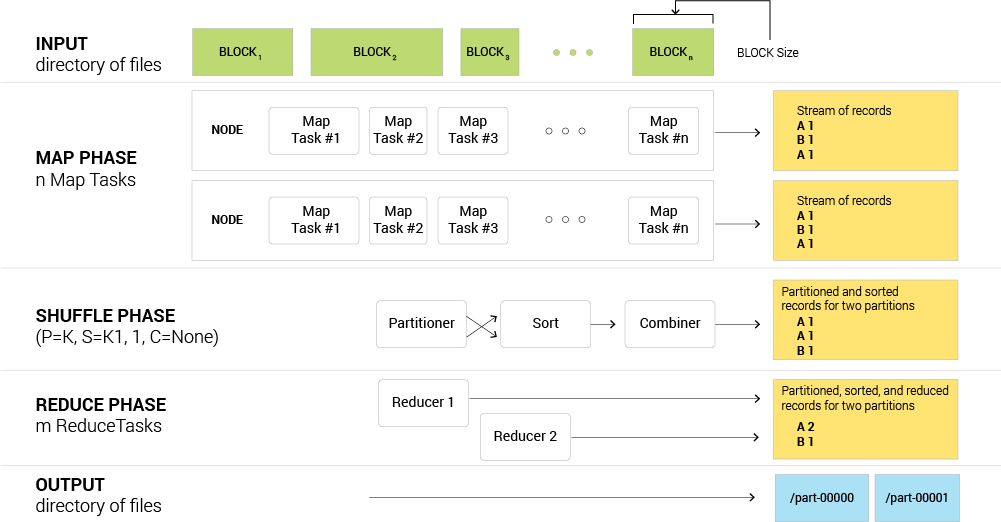

In [6]:
Image('anatomy-of-MR.png')

<em>Figure 1: Anatomy of a MapReduce Job from input data to output data via map, shuffle, and reduce steps.
</em>

<hr>
<h2><a name="Terminology">Terminology</a></h2>
<a href="#top">Back to top</a>


<a name="Hadoop"><strong>Apache Hadoop</strong></a> is a framework for running applications on large clusters built of commodity hardware. The Hadoop framework transparently provides applications both reliability and data motion. Hadoop implements a computational paradigm named Map/Reduce, where the application is divided into many small fragments of work, each of which may be executed or re-executed on any node in the cluster. In addition, it provides a distributed file system (HDFS) that stores data on the compute nodes, providing very high aggregate bandwidth across the cluster. Both MapReduce and the Hadoop Distributed File System are designed so that node failures are automatically handled by the Hadoop framework. 
http://wiki.apache.org/hadoop/

<a name="MRJob"><strong>MRJob</strong></a> is a Python library developed by Yelp to simplify writing Map/Reduce programs. It allows developers to test their code locally without installing Hadoop or run it on a cluster of choice. It also has extensive integration with Amazon Elastic Map Reduce. More information is available at  http://mrjob.readthedocs.io/en/latest/index.html

<a name="Partial-Sort"><strong>Partial Sort</strong></a> - The reducer output will be lot of (partition) files, each of which contains key-value records that are sorted within each partition file based on the key. This is the default behavior for MapReduce frameworks such as Hadoop, Hadoop Streaming and MRJob.   

<a name="Total-Sort-(Unorderd-Partitions)"><strong>Total Sort (Unordered partitions)</strong></a> - Total sort refers to an ordering of all key-value pairs based upon a specified key. This total ordering will run across all output partition files unlike the partial sort described above. One caveat here is that partition files will need to be re-stacked to generate a total ordering (a small post-processing step that is required after the map-reduce job finishes).

<a name="Total-Sort-(Ordered-Partitions)"><strong>Total Sort (Ordered partitions)</strong></a> - Total sort where the partition file names are also assigned in order.

<a name="Secondary-Sorting"><strong>Secondary Sort</strong></a> - Secondary sorting refers to controlling the ordering of records based on the key and also using the values (or part of the value). That is, sorting can be done on two or more field values.


<h2><a name="HadoopStreaming">Hadoop Streaming</a></h2>
<a href="#top">Back to top</a>

<a name="Hadoop-Streaming"><strong>[Hadoop Streaming](http://hadoop.apache.org/docs/stable1/streaming.html#Hadoop+Streaming)</strong></a> is a utility that comes with the Hadoop distribution. The utility allows a user to create and run Map-Reduce jobs with any executable or script as the mapper and/or the reducer.



In [ ]:
$HADOOP_HOME/bin/hadoop  jar $HADOOP_HOME/hadoop-streaming.jar \
    -input myInputDirs \
    -output myOutputDir \
    -mapper /bin/cat \
    -reducer /bin/wc

In the above example, both the mapper and the reducer are executables that read the input from stdin (line by line) and emit the output to stdout. The utility will create a MapReduce job, submit the job to an appropriate cluster, and monitor the progress of the job until it completes. When an executable is specified for mappers, each mapper task will launch the executable as a separate process when the mapper is initialized.    

As the mapper task runs, it converts its inputs into lines and feeds the lines to the stdin of the process. In the meantime, the mapper collects the line oriented outputs from the stdout of the process and converts each line into a key/value pair, which is collected as the output of the mapper. By default, the prefix of a line up to the first tab character is the key and the rest of the line (excluding the tab character) is the value. If there is no tab character in the line, then the entire line is considered the key and the value is null. However, this can be customized, as discussed later.   

When an executable is specified for reducers, each reducer task launches the executable as a separate process, and then the reducer is initialized. As the reducer task runs, it converts its input key/values pairs into lines and feeds the lines to the stdin of the process. In the meantime, the reducer collects the line-oriented outputs from the stdout of the process, converts each line into a key/value pair, which is collected as the output of the reducer. By default, the prefix of a line up to the first tab character is the key and the rest of the line (excluding the tab character) is the value. However, this can be customized, as discussed later.   

This is the basis for the communication protocol between the MapReduce framework and the streaming mapper/reducer.

<h2><a name="Examples">Examples of Different Sort Types (in context of Hadoop and HDFS)</a></h2>
<a href="#top">Back to top</a>


Demonstrated below is an example dataset in text format on HDFS. It includes three partitions in an HDFS directory. Each partition stores records in the format of `{Integer} [TAB] {English Word}`.

<pre>
files in hdfs directory
2016-07-20 22:04:56          0 _SUCCESS
2016-07-20 22:04:45    2392650 part-00000
2016-07-20 22:04:44    2368850 part-00001
2016-07-20 22:04:45    2304038 part-00002
</pre>
<hr />


<main>
  
  <input class="tab-state" id="tab4" type="radio" name="sortExamples" checked>
  <label for="tab4">Partial Sort</label>
    
  <input class="tab-state" id="tab5" type="radio" name="sortExamples">
  <label for="tab5">Total Sort (Unorderd Partitions)</label>
    
  <input class="tab-state" id="tab6" type="radio" name="sortExamples">
  <label for="tab6">Total Sort (Ordered Partitions)</label>
    
  <section id="content4" class="tab">

<h3>Partial Sort</h3>
<table>
<tr>
<td><pre>file: part-00000</pre></td>
<td><pre>file: part-00001</pre></td>
<td><pre>file: part-00002</pre></td>
</tr>
<tr>
<td>
<pre>
<span style="color:red">27</span>   driver
<span style="color:red">27</span>   creating
<span style="color:red">27</span>   experiements
<span style="color:red">19</span>   consists
<span style="color:red">19</span>   evaluate
<span style="color:red">17</span>   drivers
<span style="color:red">10</span>   clustering
 <span style="color:red">9</span>   during
 <span style="color:red">9</span>   change
 <span style="color:red">7</span>   contour
</pre>
</td>
<td>
<pre>
<span style="color:red">30</span>   do
<span style="color:red">28</span>   dataset
<span style="color:red">15</span>   computing
<span style="color:red">15</span>   document
<span style="color:red">15</span>   computational
<span style="color:red">14</span>   center
 <span style="color:red">5</span>   distributed
 <span style="color:red">4</span>   develop
 <span style="color:red">3</span>   different
 <span style="color:red">2</span>   cluster
</pre>
</td>
<td>
<pre>
<span style="color:red">26</span>   descent
<span style="color:red">26</span>   def
<span style="color:red">25</span>   compute
<span style="color:red">24</span>   done
<span style="color:red">24</span>   code
<span style="color:red">23</span>   descent
<span style="color:red">22</span>   corresponding
<span style="color:red">13</span>   efficient
 <span style="color:red">1</span>   cell
 <span style="color:red">0</span>   current
</pre>
</td>
</tr>
<caption align='bottom'>Keys are assigned to buckets without any ordering. Keys are sorted within each bucket (the key is the the number in the first column rendered in red).</caption>
</table>

</section>
<section id="content5" class="tab">


<h3>Total Sort (Unorderd Partitions)</h3>
<table>
<tr>
<td><pre>file: part-00000</pre></td>
<td><pre>file: part-00001</pre></td>
<td><pre>file: part-00002</pre></td>
</tr>
<tr>
<td>
<pre>
<span style="color:red">19</span> 	consists
<span style="color:red">19</span> 	evaluate
<span style="color:red">17</span> 	drivers
<span style="color:red">15</span> 	computing
<span style="color:red">15</span> 	document
<span style="color:red">15</span> 	computational
<span style="color:red">14</span> 	center
<span style="color:red">13</span> 	efficient
</pre>
</td>
<td>
<pre>
<span style="color:red">10</span>  clustering
<span style="color:red">9</span>   during
<span style="color:red">9</span>   change
<span style="color:red">7</span>   contour
<span style="color:red">5</span>   distributed
<span style="color:red">4</span>   develop
<span style="color:red">3</span>   different
<span style="color:red">2</span>   cluster
<span style="color:red">1</span>   cell
<span style="color:red">0</span>   current
</pre>
</td>
<td>
<pre>
<span style="color:red">30</span> 	do
<span style="color:red">28</span> 	dataset
<span style="color:red">27</span> 	driver
<span style="color:red">27</span> 	creating
<span style="color:red">27</span> 	experiements
<span style="color:red">26</span> 	descent
<span style="color:red">26</span> 	def
<span style="color:red">25</span> 	compute
<span style="color:red">24</span> 	done
<span style="color:red">24</span> 	code
<span style="color:red">23</span> 	descent
<span style="color:red">22</span> 	corresponding
</pre>
</td>
</tr>
<caption align='bottom'>Keys are assigned to buckets according to their numeric value. The result is that all keys between 20-30 end up in one bucket, keys between 10-20 end up in another bucket, and keys 0-10 end up in another bucket. Keys are sorted within each bucket. Partitions are not assigned in sorted order.</caption>
</table>

</section>
<section id="content6" class="tab">

<h3>Total Sort (Ordered Partitions)</h3>
<table>
<tr>
<td><pre>file: part-00000</pre></td>
<td><pre>file: part-00001</pre></td>
<td><pre>file: part-00002</pre></td>
</tr>
<tr>
<td>
<pre>
<span style="color:red">30</span> 	do
<span style="color:red">28</span> 	dataset
<span style="color:red">27</span> 	creating
<span style="color:red">27</span> 	driver
<span style="color:red">27</span> 	experiements
<span style="color:red">26</span> 	def
<span style="color:red">26</span> 	descent
<span style="color:red">25</span> 	compute
<span style="color:red">24</span> 	code
<span style="color:red">24</span> 	done
<span style="color:red">23</span> 	descent
<span style="color:red">22</span> 	corresponding
</pre>
</td>
<td>
<pre>
<span style="color:red">19</span> 	evaluate
<span style="color:red">19</span> 	consists
<span style="color:red">17</span> 	drivers
<span style="color:red">15</span> 	document
<span style="color:red">15</span> 	computing
<span style="color:red">15</span> 	computational
<span style="color:red">14</span> 	center
<span style="color:red">13</span> 	efficient
<span style="color:red">10</span> 	clustering
</pre>
</td>
<td>
<pre>
<span style="color:red">9</span> 	during
<span style="color:red">9</span> 	change
<span style="color:red">7</span> 	contour
<span style="color:red">5</span> 	distributed
<span style="color:red">4</span> 	develop
<span style="color:red">3</span> 	different
<span style="color:red">2</span> 	cluster
<span style="color:red">1</span> 	cell
<span style="color:red">0</span> 	current
</pre>
</td>
</tr>
<caption align='bottom'>Keys are assigned to buckets according to their numeric value. The result is that all keys between 20-30 end up in one bucket, keys between 10-20 end up in another bucket, and keys 0-10 end up in another bucket. Keys are sorted within each bucket. Here, partitions are assigned in sorted order, such that keys between 20-30 end up in the first bucket, keys between 10-20 end up in the second bucket, and keys 0-10 end up in the third bucket. We use the term buckets and partitions interchageably.</caption>
</table>
</section>
</main>

# Prepare Dataset
<a href="#top">Back to top</a>

Here we generate the data which we will use throughout the rest of this notebook. This is a toy dataset with 30 records, and consists of two fields in each record, separated by a tab character. The first field contains random integers between 1 and 30 (a hypothetical word count), and the second field contains English words. <strong>The goal is to sort the data by word count from highest to lowest.
</strong>

In [147]:
%%writefile generate_numbers.py
#!/usr/bin/python
words = ["cell","center","change","cluster","clustering","code","computational","compute","computing","consists",\
         "contour","corresponding","creating","current","dataset","def","descent","descent","develop","different",\
         "distributed","do","document","done","driver","drivers","during","efficient","evaluate","experiements"]
import random
N = 30
for n in range(N):
    print random.randint(0,N),"\t",words[n]

Overwriting generate_numbers.py


In [5]:
# give the python file exacutable permissions, write the file, and inspect number of lines
!chmod +x generate_numbers.py;
!./generate_numbers.py > generate_numbers.output
!wc -l generate_numbers.output

      30 generate_numbers.output


In [24]:
# view the raw dataset
!cat generate_numbers.output

1	cell
14	center
9	change
2	cluster
10	clustering
24	code
15	computational
25	compute
15	computing
19	consists
7	contour
22	corresponding
27	creating
0	current
28	dataset
26	def
26	descent
23	descent
4	develop
3	different
5	distributed
30	do
15	document
24	done
27	driver
17	drivers
9	during
13	efficient
19	evaluate
27	experiements


<h1><a name="Section1">Section I - Understanding Unix Sort</a></h1>
<a href="#top">Back to top</a>

<h2><a name="importance-of-unix-sort">Importance of Unix Sort</a></h2>
<a href="#top">Back to top</a>  | <a href="#Section1">Back to Section I</a>   

Sort is a simple and very useful command found in Unix systems. It rearranges lines of text numerically and/or alphabetically. Hadoop Streaming's KeyBasedComparator is modeled after Unix sort, and utilizes command line options which are the same as Unix sort command line options.

<h3><a name="unix-sort-overview">Unix Sort Overview</a></h3>
<a href="#top">Back to top</a>  | <a href="#Section1">Back to Section I</a>

```
# sort syntax
sort [OPTION]... [FILE]...
```

Sort treats a single line of text as a single datum to be sorted. It operates on fields (by default, the whole line is considered a field). It uses tabs as the delimiter by default (which can be configured with -t option), and splits a (non-empty) line into one or more parts, whereby each part is considered a field. Each field is identified by its index (POS).   

The most important configuration option is perhaps -k or --key.
Start a key at POS1 (origin 1), end it at POS2 (default end of line):

```
-k, --key=POS1[,POS2]
```

For example, -k1 (without ending POS), produces a key that is the whole line, and -k1,1 produces a key that is the first field. Multiple -k options can be supplied, and applied left to right. Sort keys can be tricky sometimes, and should be treated with care. For example:


```
sort –k1 –k2,2n
``` 

Will not work properly, as -k1 uses the whole line as key, and trumps -k2,2n.   

Another example:

```
sort -k2 -k3
```

This is redundant: it's equivalent to sort -k2.   

A good practice for supplying multiple sort keys is to make sure they are non-overlapping. 

Other commonly used flags/options are: -n, which sorts the keys numerically, and -r which reverses the sort order.



<h2><a name="sort-examples">  <span style="font-weight:normal;">`sort`</span> examples </a></h2>
<a href="#top">Back to top</a>  | <a href="#Section1">Back to Section I</a>

(Source: http://www.theunixschool.com/2012/08/linux-sort-command-examples.html)

In [3]:
%%writefile unix-sort-example.txt
Unix,30
Solaris,10
Linux,25
Linux,20
HPUX,100
AIX,25

Overwriting unix-sort-example.txt


<main>
  
  <input class="tab-state" id="tab7" type="radio" name="moreSortExamples" checked>
  <label for="tab7">sort -t"," -k1,1</label>
    
  <input class="tab-state" id="tab8" type="radio" name="moreSortExamples">
  <label for="tab8">sort -t"," -k2,2nr</label>
    
  <input class="tab-state" id="tab9" type="radio" name="moreSortExamples">
  <label for="tab9">sort -t"," -k1,1 -k2,2nr</label>
    
  <section id="content7" class="tab">


Sort by field 1 (default alphabetically), deliminator ","    


<table>
<tr>
<td><pre>cat unix-sort-example.txt</pre></td>
<td><pre>sort -t"," -k1,1 unix-sort-example.txt</pre></td>
</tr>
<tr>
<td><pre>
Unix,30
Solaris,10
Linux,25
Linux,20
HPUX,100
AIX,25
</pre></td>
<td><pre>
AIX,25
HPUX,100
Linux,20
Linux,25
Solaris,10
Unix,30
</pre></td>
</tr>
</table>

</section>
<section id="content8" class="tab">

Sort by field 2 numerically reverse, deliminator ","   

<table>
<tr>
<td><pre>cat unix-sort-example.txt</pre></td>
<td><pre>sort -t"," -k2,2nr  unix-sort-example.txt</pre></td>
</tr>
<tr>
<td><pre>
Unix,30
Solaris,10
Linux,25
Linux,20
HPUX,100
AIX,25
</pre></td>
<td><pre>
HPUX,100
Unix,30
AIX,25
Linux,25
Linux,20
Solaris,10
</pre></td>
</tr>
</table>

</section>
<section id="content9" class="tab">

Sort by field 1 alphabetically first, then by field 2 numeric reverse   

<table>
<tr>
<td><pre>cat unix-sort-example.txt</pre></td>
<td><pre>sort -t"," -k1,1 -k2,2nr  unix-sort-example.txt</pre></td>
</tr>
<tr>
<td><pre>
Unix,30
Solaris,10
Linux,25
Linux,20
HPUX,100
AIX,25
</pre></td>
<td><pre>
AIX,25
HPUX,100
Linux,25
Linux,20
Solaris,10
Unix,30
</pre></td>
</tr>
</table>

</section>
</main>

<h1><a name="Section2">Section II - Hadoop Streaming</a></h1>
<a href="#top">Back to top</a>   
<ul class="toc-item">
    <li><a href="#II.A.-Hadoop's-Default-Sorting-Behavior">II.A. Hadoop's Default Sorting Behavior</a></li>
    <li><a href="#Hadoop-streaming-parameters">II.B. Hadoop Streaming parameters</a></li>
    <ul>
      <li><a href="#Configure-Hadoop-Streaming-0"> Configure Hadoop Streaming: Prerequisites</a></li>
      <li><a href="#Configure-Hadoop-Streaming-1"> Configure Hadoop Streaming: Step 1</a></li>
      <li><a href="#Configure-Hadoop-Streaming-2"> Configure Hadoop Streaming: Step 2</a></li>
      <li><a href="#Configure-Hadoop-Streaming-3">Configure Hadoop Streaming: Step 3</a></li>
      <li><a href="#Summary-of-Common-Practices">Summary of Common Practices of Sorting Related Configuration</a></li>
      <li><a href="#Side-by-side-Examples">Side-by-side Examples: unix sort vs. hadoop streaming</a></li>
    </ul>
    </li>
    <li>
      <a href="#Hadoop-streaming-implementation">II.C. Hadoop Streaming implementation</a>
      <ul>
        <li><a href="#single-reducer-hadoop-streaming">II.C.1. Hadoop Streaming Implementation - single reducer</a></li>
        <li><a href="#multiple-reducer-hadoop-streaming">II.C.2. Hadoop Streaming Implementation - multiple reducers</a>
          <ul>
            <li><a href="#What's-new:-">What's New</a></li>
            <li><a href="#Multiple-Reducer-Overview">Multiple Reducer Overview</a></li>
            <li><a href="#Introductory-Example:">Introductory Example</a></li>
            <li><a href="#Implementation-Walkthrough">Implementation Walkthrough</a></li>
            
          </ul>
        </li>
      </ul>
    </li>
</ul>

<h2><a name="Hadoop's-Default-Sorting-Behavior">II.A. Hadoop's Default Sorting Behavior</a></h2>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 
<h4>Key points:</h4> 
<ul>
<li>By default, Hadoop performs a partial sort on mapper output keys, i.e. within each partition keys are sorted.
</li>
<li>By default, keys are sorted as strings.
    <ul>
        <li>When processing a mapper output record, first the partitioner decides which partition the record should be sent to.</li>
        <li>In shuffle and sort stage, keys within a partition are sorted. </li>
        </ul>
</li>
<li>If there is only one partition, mapper output keys will be sorted in total order</li>
<li>The partition index of a given key from mapper outputs is determined by the partitioner, the  default partitioner is HashPartitioner which relies on Java’s hashCode function to compute an integer hash for the key. The partition index is derived next by hash modulo number of reducers.
</li>
</ul>

<h2><a name="Hadoop-streaming-parameters">II.B. Hadoop Streaming parameters</a></h2>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 

Hadoop streaming can be further fine-grain controlled through the command line options below. Through these, we can fine-tune the Hadoop framework to better understand line-oriented record structure, and achieve the versatility of single-machine Unix sort, but in a distributed and efficient manner.


```
stream.num.map.output.key.fields
stream.map.output.field.separator
mapreduce.partition.keypartitioner.options
KeyFieldBasedComparator
keycomparator.options
partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner
```
In a sorting task, Hadoop Streaming provides the same interface as Unix sort. Both consume a stream of lines of text, and produce a permutation of input records, based on one or more sort keys extracted from each line of input. Without customizing its sorting and partitioning, Hadoop Streaming treats implicitly each input line as a record consisting of a single key and value, separated by a "tab" character.   

Just like the various options Unix sort offers, Hadoop Streaming can be customized to use multiple fields for sorting, sort records by numeric order or keys and sort in reverse order.   

The following table provides an overview of relationships between Hadoop Streaming sorting and Unix sort:

<table width="100%">
<tr>
    <th></th>
    <th>Unix `sort`   </th>
    <th>Hadoop streaming</th>
</tr>
<tr>
    <td>Key Field Separator</td>
    <td>`-t`</td>
    <td>`-D stream.map.output.field.separator`</td>
</tr>
<tr>
    <td>Number of Key Fields</td>
    <td>Not Required</td>
    <td>`-D stream.num.map.output.key.fields`</td>
</tr>
<tr>
    <td>Key Range</td>
    <td>`-k, --key=POS1[,POS2]`</td>
    <td>`-D mapreduce.partition.keycomparator.options`   (same syntax as unix sort)</td>
</tr>
<tr>
    <td>Numeric Sort</td>
    <td>`-n, --numeric-sort`</td>
    <td>`-D mapreduce.partition.keycomparator.options`   (same syntax as unix sort)</td>
</tr>
<tr>
    <td>Reverse Order</td>
    <td>`-r --reverse`</td>
    <td>`-D mapreduce.partition.keycomparator.options`   (same syntax as unix sort)</td>
</tr>
<tr>
    <td>Partitioner Class</td>
    <td>Not Applicable</td>
    <td>`-partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner`</td>
</tr>
<tr>
    <td>Comparator Class</td>
    <td>Not Applicable</td>
    <td>`-D mapreduce.job.output.key.comparator.class`</td>
</tr>
<tr>
    <td>Partition Key Fields</td>
    <td>Not Applicable</td>
    <td>`-D mapreduce.partition.keypartitioner.options`</td>
</tr>
</table>


Therefore, given a distributed sorting problem, it is always helpful to start with a non-scalable solution that can be provided by Unix sort and work out the required Hadoop Streaming configurations from there.


<h3><a name="Configure-Hadoop-Streaming-0"> Configure Hadoop Streaming: Prerequisites</a></h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a>    

```
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner        
```

These two options instruct Hadoop Streaming to use two specific Hadoop Java library classes: KeyFieldBasedComparator and KeyFieldBasedPartitioner. They come in standard Hadoop distribution, and provide the required machinery.


<h3><a name="Configure-Hadoop-Streaming-1"> Configure Hadoop Streaming: Step 1</a></h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a>     

Specify number of key fields and key field separator

```
  -D stream.num.map.output.key.fields=4 \
  -D mapreduce.map.output.key.field.separator=.
```

In Unix sort when input lines use a non-tab delimiter, we need to supply the -t separator option. Similarly in Hadoop Streaming, we need to specify the character to use as key separators. Common options include: comma",", period ".", and space " ".   

One additional hint to Hadoop is the number of key fields, which is not required for Unix sort. This helps Hadoop Streaming to only parse the relevant parts of input lines, as in the end only keys are sorted (not values) – therefore, Hadoop can avoid performing expensive parsing and sorting on value parts of input line records.


<h3><a name="Configure-Hadoop-Streaming-2">Configure Hadoop Streaming: Step 2</a></h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a>     

Specify sorting options

```
  -D mapreduce.partition.keycomparator.options=-k2,2nr 
```

This part is very straightforward. Whatever one would do with Unix sort (eg. -k1,1 -k3,4nr), just mirror it for Hadoop Streaming. However it is crucial to remember that Hadoop only uses KeyFieldBasedComparator to sort records within partitions. Therefore, this step only helps achieve partial sort.

<h3><a name="Configure-Hadoop-Streaming-3">Configure Hadoop Streaming: Step 3</a></h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a>     


Specify partition key field

```
  -D mapreduce.partition.keypartitioner.options=-k1,1
```

In this step, we need to specify which key field to use for partitioning. There's no equivalent in Unix sort. One critical detail to keep in mind is that, even though Hadoop Streaming uses Unix sort --key option's syntax for mapreduce.partition.keypartitioner.options., no sorting will actually be performed. It only uses expressions such as -k2,2nr for key extraction; the nr flags will be ignored.   

In later sections (Partitioning in MRJob), we will discuss in detail how to incorporate sorting into the partitioner by custom partition key construction.


<h2><a name="Summary-of-Common-Practices">Summary of Common Practices for Sorting Related Configuration</a></h2>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a>    

<!-- HTML generated using hilite.me --><div style="background: #ffffff; overflow:auto;width:auto;border:0;border-width:.0;padding:.0;"><pre style="margin: 0; line-height: 125%">  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
  -D stream.num.map.output.key.fields=<span style="color: #0000FF">4</span> \
  -D map.output.key.field.separator=. \
  -D mapreduce.partition.keypartitioner.options=<span style="color: #0000FF">-k1,2</span> \
  -D mapreduce.job.reduces=<span style="color: #0000FF">12</span> \
</pre></div>


At bare minimum, we typically need to specify:

1. Use KeyFieldBasedPartitioner
2. Use KeyFieldBasedComparator
3. Key field separator (can be omitted if TAB is used as separator)
4. Number of key fields
5. Key field separator again for mapper (under a different config option)
6. Partitioner options (Unix sort syntax)
7. Number of reducer jobs

See [hadoop streaming official documentation](https://hadoop.apache.org/docs/r2.7.2/hadoop-streaming/HadoopStreaming.html) for more information (hadoop version = 2.7.2).


<h3><a name="Side-by-side-Examples">Side-by-side Examples: Unix sort vs. Hadoop Streaming</a></h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 

<table width="100%">
<tbody>

<tr>
    <td width="20%">Unix sort</td>
    <td>Hadoop Streaming</td>
</tr>


<tr>
<td>
`sort -t"," -k1,1`
</td>
<td>
```
-D mapreduce.job.output.key.comparator.class=\
  org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
-D stream.num.map.output.key.fields=2 \
-D stream.map.output.field.separator="," \
-D mapreduce.partition.keypartitioner.options=-k1,1\
-partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner\
-D mapreduce.job.reduces=1
```
</td>
</tr>

<tr>
<td>
`sort -k1,1 -k2,3nr`
</td>
<td>
```
-D mapreduce.job.output.key.comparator.class=\
  org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
-D stream.num.map.output.key.fields=3 \
-D mapreduce.partition.keypartitioner.options="-k1,1 -k2,3nr"\
-partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner\
-D mapreduce.job.reduces=1
```
</td>
</tr>


</tbody>
</table>

Note: in both examples we use only a single reduce job, which makes hadoop's partial sort equivalent to a total sort.

<h2><a name="Hadoop-streaming-implementation">II.C. Hadoop Streaming implementation</a></h2>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 

You will need to install, configure, and start Hadoop. Brief instructions follow, but detailed instructions are beyond the scope of this notebook.


<h3><a name="StartHadoop">Start Hadoop</a></h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 


To run the examples in this notebook you must download and configure hadoop on your local computer. Go to http://hadoop.apache.org/ for the latest downloads. 

Everything you need to get up and running can be found on this page: https://hadoop.apache.org/docs/r2.7.2/hadoop-project-dist/hadoop-common/SingleCluster.html. There are also many websites with specialized instructions.

Once all components have been downloaded and installed, you can check that everything is running by running the `jps` command in your terminal. You should see output like this:
```
localhost:~ $ jps
83360 NodeManager
82724 DataNode
82488 NameNode
82984 SecondaryNameNode
83651 Jps
83118 ResourceManager
83420 JobHistoryServer
```

This notebook runs on the following setup:
```
Mac OX Yosemite 10.10.5
Java version "1.7.0_51"
Hadoop version 2.7.2
```


In [26]:
# should you need to regenerate the file and put it in hdfs a second time, make sure to delete the existing file first:
!hdfs dfs -rm -r /user/koza/sort

16/08/20 19:24:29 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/koza/sort


In [27]:
# put the file in hdfs:
!hdfs dfs -mkdir /user/koza/sort
!hdfs dfs -mkdir /user/koza/sort/output
!hdfs dfs -put generate_numbers.output /user/koza/sort

In [18]:
# make sure it's really there:
!hdfs dfs -ls /user/koza/sort/generate_numbers.output

-rw-r--r--   1 koza supergroup        486 2016-08-20 19:17 /user/koza/sort/generate_numbers.output


<h2><a name="single-reducer-hadoop-streaming">II.C.1. Hadoop Streaming Implementation - single reducer</a></h2>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 

<h3>Key points:</h3> 
<ul>
    <li>Single reducer guarantees a single partition</li>
    <li>Partial sort becomes total sort</li>
    <li>No need for secondary sorting </li>
    <li>Single Reducer becomes scalibility bottleneck</li>
</ul>
<h3>Steps</h3>

In the mapper shuffle sort phase, the data is sorted by the primary key, and sent to a single reducer. By specifying `/bin/cat/` for the mapper and reducer, we are telling Hadoop Streaming to use the identity mapper and reducer which simply output the input (Key,Value) pairs.

<h4>Setup:</h4>
```
-D stream.num.map.output.key.fields=2 
-D stream.map.output.field.separator="\t" 
-D mapreduce.partition.keycomparator.options="-k1,1nr -k2,2" 
```
First we'll specify the number of keys, in our case, 2. The count and the word are primary and secondary keys, respectively. Next we'll tell Hadoop Streaming that our field separator is a tab character. Lastly we'll use the keycompartor options to specify which keys to use for sorting. Here, -n specifies that the sorting is numerical for the primary key, and -r specifies that the result should be reversed, followed by k2 which will sort the words alphabetically to break ties. Refer to the Unix sort section above.

<span style="color:red"><strong>IMPORTANT:</strong></span> Hadoop Streaming is particular about the order in which options are specified.  

(For more information, see the docs here: https://hadoop.apache.org/docs/r1.2.1/streaming.html#Hadoop+Comparator+Class)

In [6]:
!hdfs dfs -rm -r /user/koza/sort/output
!hadoop jar /usr/local/Cellar/hadoop/2.7.2/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar \
-D stream.num.map.output.key.fields=2 \
-D stream.map.output.field.separator="\t" \
-D mapreduce.partition.keypartitioner.options=-k1,1 \
-D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapreduce.partition.keycomparator.options="-k1,1nr -k2,2" \
-mapper /bin/cat \
-reducer /bin/cat \
-input /user/koza/sort/generate_numbers.output \
-output /user/koza/sort/output \


In [4]:
# Check to see that we have indeed generated a single output file
!hdfs dfs -ls /user/koza/sort/output

Found 2 items
-rw-r--r--   1 koza supergroup          0 2017-01-27 11:19 /user/koza/sort/output/_SUCCESS
-rw-r--r--   1 koza supergroup        363 2017-01-27 11:19 /user/koza/sort/output/part-00000


In [5]:
# Print the results
print "="*100
print "Single Reducer Sorted Output - Hadoop Streaming"
print "="*100
!hdfs dfs -cat /user/koza/sort/output/part-00000

Single Reducer Sorted Output - Hadoop Streaming
30	do	
28	dataset	
27	creating	
27	driver	
27	experiements	
26	def	
26	descent	
25	compute	
24	code	
24	done	
23	descent	
22	corresponding	
19	consists	
19	evaluate	
17	drivers	
15	computational	
15	computing	
15	document	
14	center	
13	efficient	
10	clustering	
9	change	
9	during	
7	contour	
5	distributed	
4	develop	
3	different	
2	cluster	
1	cell	
0	current	


<h2><a name="multiple-reducer-hadoop-streaming">II.C.2. Hadoop Streaming Implementation - multiple reducers</a></h2>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 


<h3>Key points:</h3> 
<ul>
    <li>Need to guarantee that every key in a single reducer is to be "pre-sorted" against all other reducers</li>
    <li>Requires knowledge of the distribution of values to be sorted - more about this later in the sampling section</li>
    <li>Uses secondary sort to order keys within each partition</li>
</ul>


<h3><strong>What's new</strong>: </h3>  

Now the mapper needs to emit an additional key for each record by which to partition. We partition by this new 'primary' key and sort by secondary and tertiary keys to break ties. Here, the partition key is the primary key.   

The following diagram illustrates the steps required to perform total sort in a multi-reducer setting:


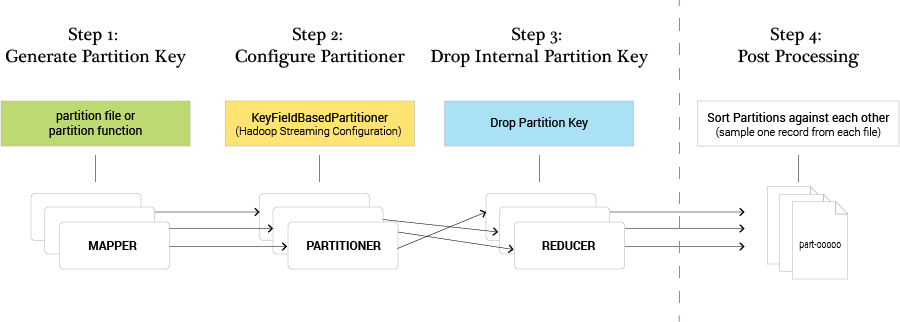

In [92]:
Image("TotalSortSteps2.png")

<em>Figure 2. Total Order sort with multiple reducers</em>

<h3>Multiple Reducer Overview</h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 
   
<p></p>
After the Map phase and before the beginning of the Reduce phase there is a handoff process, known as shuffle and sort. Output from the mapper tasks is prepared and moved to the nodes where the reducer tasks will be run. To improve overall efficiency, records from mapper output are sent to the physical node that a reducer will be running on as they are being produced - to avoid flooding the network when all mapper tasks are complete.   

What this means is that when we have more than one reducer in a MapReduce job, Hadoop no longer sorts the keys globally (total sort). Instead mapper outputs are partitioned while they're being produced, and before the reduce phase starts, records are sorted by the key within each partition. In other words, Hadoop's architecture only guarantees partial sort.   

Therefore, to achieve total sort, a programmer needs to incorporate additional steps and supply the Hadoop framework additional aid during the shuffle and sort phase. Particularly, a partition file or partition function is required.

<h4>Modification 1: Include a partition file or partition function inside mappers</h4>

Recall that we can use an identity mapper in single-reducer step up, which just echos back the (key, value) pair from input data. In a multi-reducer setup, we will need to add an additional "partition key" to instruct Hadoop how to partition records, and pass through the original (key, value) pair.   

The partition key is derived from the input key, with the help of either a partition file (more on this in the sampling section) or a user-specified partition function, which takes a key as input, and produces a partition key. Different input keys can result in same partition key.

<h4>Modification 2: Drop internal partition key inside reducers</h4>

Now we have two keys (as opposed to just one), and one is used for partitioning, the other is used for sorting. The reducer needs to drop the partition key which is used internally to aid total sort, and recover the original (key, value) pairs.

<h4>Modification 3: Post-processing step to order partitions</h4>

The MapReduce job output is written to HDFS, with the output from each partition in a separate file (usually named something such as: part-00000). These file names are indexed and ordered. However, Hadoop makes no attempt to sort partition keys – the mapping between partition key and partition index is not order-preserving. Therefore, while partition keys key_1, key_2 and key_1 < key_2, it's possible that the output of partition with key_1 could be written to file part-00006 and the output of partition with key_2 written to file part-00003.   

Therefore, a post-processing step is required to finish total sort. We will need to take one record from every (non-empty) partition output, sort them, and construct the appropriate ordering among partitions.


<h3>Introductory Example:</h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 

Consider the task of sorting English words alphabetically, for example, four words from our example dataset:

<pre style="color: #BA2121">
experiements	
def	
descent	
compute	
</pre>

The expected sorted output is:
<pre style="color: #BA2121">
compute	
def	
descent	
experiements	
</pre>

We can use the first character from each word as a partition key. The input data could potentially have billions of words, but we will never have more than 26 unique partition keys (assuming all words are lower-cased). In addition, a word starting with "a" will always have a lower alphabetical ordering compared to a word which starts with "z". Therefore, all words belonging to partition "a" will be "pre-sorted" against all words from partition "z". The technique described here is equivalent to the following partition function:

<!-- HTML generated using hilite.me --><div style="background: #f8f8f8; overflow:auto;width:auto;border:0;border-width:.0;padding:.0;"><pre style="margin: 0; line-height: 125%"><span style="color: #008000; font-weight: bold">def</span> <span style="color: #0000FF">partition_function</span>(word):
    <span style="color: #008000; font-weight: bold">assert</span> <span style="color: #008000">len</span>(word) <span style="color: #666666">&gt;</span> <span style="color: #666666">0</span>
    <span style="color: #008000; font-weight: bold">return</span> word[<span style="color: #666666">0</span>]
</pre></div>

It is important to note that a partition function must preserve sort order, i.e. all partitions need to be sorted against each other. For instance, the following partition function is not valid (in sorting words in alphabetical order):

<!-- HTML generated using hilite.me --><div style="background: #f8f8f8; overflow:auto;width:auto;border:0;border-width:.0;padding:.0;"><pre style="margin: 0; line-height: 125%"><span style="color: #008000; font-weight: bold">def</span> <span style="color: #0000FF">partition_function</span>(word):
    <span style="color: #008000; font-weight: bold">assert</span> <span style="color: #008000">len</span>(word) <span style="color: #666666">&gt;</span> <span style="color: #666666">0</span>
    <span style="color: #008000; font-weight: bold">return</span> word[<span style="color: #666666">-1</span>]
</pre></div>



The mapper output or the four words with this partition scheme is:
<pre style="color: #BA2121">
e    experiements	
d    def	
d    descent	
c    compute	
</pre>

The following diagram outlines the flow of data with this example:

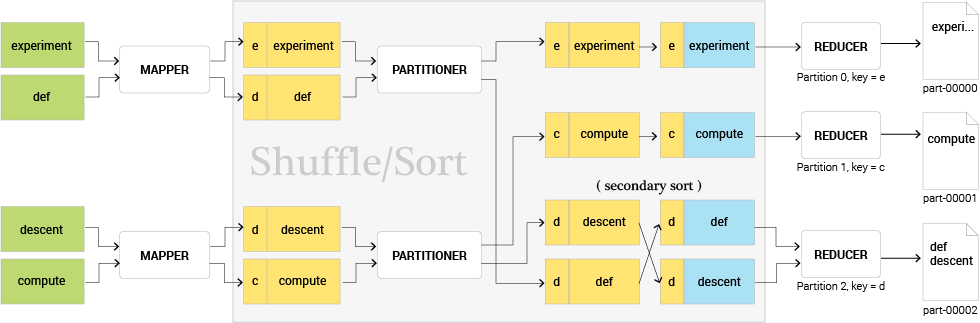

In [45]:
Image(filename="Partition2.png")

<em>Figure 3. Partial Order Sort</em>

Note that partition key "e" maps to partition 0, even if it is "greater than" key "d" and "c". This illustrates that the mapping between partition key and partition indices are not order preserving. In addition, sorting within partitions is based on the original key (word itself).


<h3>Implementation Walkthrough</h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 

Coming back to our original dataset, here we will sort and print the output in two steps. Step one will partition and sort the data, and step two will arrange the partitions in the appropriate order. In the MRJob implementation that follows, we'll build on this and demonstrate how to ensure that the partitions are created in the appropriate order to begin with.

<ol>
    <li>Run the Hadoop command that prepends an alphabetic key to each row such that they end up in the appropriate partition, shuffle, and sort. </li>
    <li>Combine the secondary sort output files in the appropriate order</li>
</ol>

<h4>Setup</h4>

The following options comprise the Hadoop Streaming configuration for the sort job. Notice the addition of the keypartitioner option, which tells Hadoop Streaming to partition by the primary key. Remember that the order of the options is important.

```
-D stream.num.map.output.key.fields=3 \
-D stream.map.output.field.separator="\t" \
-D mapreduce.partition.keypartitioner.options=-k1,1 \
-D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapreduce.partition.keycomparator.options="-k1,1 -k2,2nr -k3,3" \
```

Here, "-k1,1 -k2,2nr -k3,3" performs secondary sorting. Our three key fields are:

* `-k1,1`: partition key, one of $\{A, B, C\}$ (this part is optional, since each partition will contain the same partition key)
* `-k2,2nr`: input key (number/count), and we specify `nr` flags to sort them numerically reverse 
* `-k3,3`  : input value (word), if two records have same count, we break the tie by comparing the words alphabetically

### Function to prepend an alphabetic key to each row such that they end up in the appropriate partition

The following mapper is an identity mapper with a partition function included, it prepends an alphabetic key as partition key to input records.

In [4]:
%%writefile prependPartitionKeyMapper.py
#!/usr/bin/env python
import sys
for line in sys.stdin:
    line = line.strip()
    key, value = line.split("\t")
    if int(key) < 10:
        print "%s\t%s\t%s" % ("A", key, value)   
    elif int(key) < 20:
        print "%s\t%s\t%s" % ("B", key, value)   
    else:
        print "%s\t%s\t%s" % ("C", key, value)    

Overwriting prependPartitionKeyMapper.py


### __Step 1 - run the hadoop command specifying 3 reducers, the partition key, and the sort keys__

In [132]:
!hdfs dfs -rm -r /user/koza/sort/secondary_sort_output
!hadoop jar /usr/local/Cellar/hadoop/2.7.2/libexec/share/hadoop/tools/lib/hadoop-streaming-2.7.2.jar \
    -D stream.num.map.output.key.fields=3 \
    -D stream.map.output.field.separator="\t" \
    -D mapreduce.partition.keypartitioner.options=-k1,1 \
    -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    -D mapreduce.partition.keycomparator.options="-k1,1 -k2,2nr -k3,3" \
    -mapper prependPartitionKeyMapper.py \
    -reducer /bin/cat \
    -file prependPartitionKeyMapper.py -input /user/koza/sort/generate_numbers.output \
    -output /user/koza/sort/secondary_sort_output \
    -numReduceTasks 3 \
    -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner 

<h3> Check the output </h3>

In [29]:
!hdfs dfs -ls /user/koza/sort/secondary_sort_output
print "="*100
print "/part-00000"
print "="*100
!hdfs dfs -cat /user/koza/sort/secondary_sort_output/part-00000
print "="*100
print "/part-00001"
print "="*100
!hdfs dfs -cat /user/koza/sort/secondary_sort_output/part-00001
print "="*100
print "/part-00002"
print "="*100
!hdfs dfs -cat /user/koza/sort/secondary_sort_output/part-00002

Found 4 items
-rw-r--r--   1 koza supergroup          0 2016-08-20 19:25 /user/koza/sort/secondary_sort_output/_SUCCESS
-rw-r--r--   1 koza supergroup        141 2016-08-20 19:25 /user/koza/sort/secondary_sort_output/part-00000
-rw-r--r--   1 koza supergroup        164 2016-08-20 19:25 /user/koza/sort/secondary_sort_output/part-00001
-rw-r--r--   1 koza supergroup        118 2016-08-20 19:25 /user/koza/sort/secondary_sort_output/part-00002
/part-00000
B	19	consists	
B	19	evaluate	
B	17	drivers	
B	15	computational	
B	15	computing	
B	15	document	
B	14	center	
B	13	efficient	
B	10	clustering	
/part-00001
C	30	do	
C	28	dataset	
C	27	creating	
C	27	driver	
C	27	experiements	
C	26	def	
C	26	descent	
C	25	compute	
C	24	code	
C	24	done	
C	23	descent	
C	22	corresponding	
/part-00002
A	9	change	
A	9	during	
A	7	contour	
A	5	distributed	
A	4	develop	
A	3	different	
A	2	cluster	
A	1	cell	
A	0	current	


### Step 2 - Combine the sorted output files in the appropriate order
The following code block peaks at the first line of each partition file to determine the order of partitions, and prints the contents of each partition in order, from largest to smallest. Notice that, while the files are arranged in total order, the partition file names are not ordered. We’ll tackle this issue in the MRJob implementation.


In [3]:
# The subprocess module allows you to spawn new (system) processes, connect to their input/output/error pipes, 
# and obtain their return codes. Ref: https://docs.python.org/2/library/subprocess.html
import subprocess 
import re



'''
subprocess.Popen()
Opens a new subprocess and executes the unix command in the args array, passing the output to STDOUT.
This is the equivalent of typing: 
hdfs dfs -ls /user/koza/sort/secondary_sort_output/part-*
in the unix shell prompt
Even though we cannot see this output it would look like this:
-rw-r--r--   1 koza supergroup        141 2016-08-20 19:25 /user/koza/sort/secondary_sort_output/part-00000
-rw-r--r--   1 koza supergroup        164 2016-08-20 19:25 /user/koza/sort/secondary_sort_output/part-00001
-rw-r--r--   1 koza supergroup        118 2016-08-20 19:25 /user/koza/sort/secondary_sort_output/part-00002
'''

p = subprocess.Popen(["hdfs", "dfs", "-ls", "/user/koza/sort/secondary_sort_output/part-*" ],  
                     stdout=subprocess.PIPE, stderr=subprocess.STDOUT)


'''
Save the output of the above command to the 'lines' string variable by reading each line and appending it to the 'lines' string.
The resulting lines string should look like this:

'-rw-r--r--   1 koza supergroup        141 2016-08-20 19:25 /user/koza/sort/secondary_sort_output/part-00000\n-rw-r--r--   1 koza supergroup        164 2016-08-20 19:25 /user/koza/sort/secondary_sort_output/part-00001\n-rw-r--r--   1 koza supergroup        118 2016-08-20 19:25 /user/koza/sort/secondary_sort_output/part-00002\n'

'''
lines=""
for line in p.stdout.readlines():
    lines = lines + line

    
'''
The following regular expresion extracts the paths from 'lines', and appends each path to the outputPARTFiles list.
The resulting outputPARTFiles list should look like this:

['/user/koza/sort/secondary_sort_output/part-00000',
 '/user/koza/sort/secondary_sort_output/part-00001',
 '/user/koza/sort/secondary_sort_output/part-00002']

'''    
regex = re.compile('(\/user\/koza\/sort\/secondary_sort_output\/part-\d*)')
it = re.finditer(regex, lines)

outputPARTFiles=[]
for match in it:
    outputPARTFiles.append(match.group(0))

'''
Next is where we peek at the first line of each file and extract the key. The resulting partKeys list should look like this:
[19, 30, 9]

For each file f in outputPARTFiles
    int(...)                            <-- this will convert the key returned by the commands that follow to an integer
    ["hdfs", "dfs", "-cat", f]          <-- cat the file 
    stdout=subprocess.PIPE              <-- to STDOUT
    stdout.read()                       <-- read the STDOUT into memory
    splitlines()[0]                     <-- split that output into lines, and return the first line (at index 0)
    split('\t')[1]                      <-- split that first line by tab character, and return the item at index 1 - this is the 'key'
    strip()                             <-- remove trailing and leading spaces so output is clean

'''    
partKeys=[]
for f in outputPARTFiles:
    partKeys.append(int(subprocess.Popen(["hdfs", "dfs", "-cat", f], 
                             stdout=subprocess.PIPE).stdout.read().splitlines()[0].split('\t')[1].strip()))

    
'''
create a dict d assoicating each key with its corresponding file path. The resulting d dict should look like this:

{9: '/user/koza/sort/secondary_sort_output/part-00002',
 19: '/user/koza/sort/secondary_sort_output/part-00000',
 30: '/user/koza/sort/secondary_sort_output/part-00001'}
 
 ^^ we now know that the largest key lives in part-00001, and we will display that file content first

'''    
d={}
for i in range(len(outputPARTFiles)):
    print "part is %d, key is %d, %s" %(i, partKeys[i], outputPARTFiles[i])
    d[partKeys[i]] = outputPARTFiles[i]

'''
Print the contents of each file in total sorted order, by sorting the d dict by key in reverse:

    sorted(d.items(), key=lambda x: x[0], reverse=True)   <-- sorts d dict by key x[0], in reverse
    print "%d:%s"%(k[0], k[1])                            <-- print the key k[0] and the path k[1]
    
    use a subprocess to read the contents of each file listed in d (k[1]) (see explanation above for subprocess)
    and print each line omitting leading and trailing spaces
'''
    
#TOTAL Sort in decreasing order
for k in sorted(d.items(), key=lambda x: x[0], reverse=True):
    print "="*100
    print "%d:%s"%(k[0], k[1])
    print "="*100
    p = subprocess.Popen(["hdfs", "dfs", "-cat", k[1]],  stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    for line in p.stdout.readlines():
        print line.strip()


part is 0, key is 19, /user/koza/sort/secondary_sort_output/part-00000
part is 1, key is 30, /user/koza/sort/secondary_sort_output/part-00001
part is 2, key is 9, /user/koza/sort/secondary_sort_output/part-00002
30:/user/koza/sort/secondary_sort_output/part-00001
C	30	do
C	28	dataset
C	27	creating
C	27	driver
C	27	experiements
C	26	def
C	26	descent
C	25	compute
C	24	code
C	24	done
C	23	descent
C	22	corresponding
19:/user/koza/sort/secondary_sort_output/part-00000
B	19	consists
B	19	evaluate
B	17	drivers
B	15	computational
B	15	computing
B	15	document
B	14	center
B	13	efficient
B	10	clustering
9:/user/koza/sort/secondary_sort_output/part-00002
A	9	change
A	9	during
A	7	contour
A	5	distributed
A	4	develop
A	3	different
A	2	cluster
A	1	cell
A	0	current


<h1><a name="Section3">Section III - MRJob</a></h1>
<a href="#top">Back to top</a>  

For this section you will need the MRJob Python  library. For installation instructions, go to: https://github.com/Yelp/mrjob   

We'll first discuss a couple of key aspects of MRJob such as modes, protocols, and partitioning, before diving into the implementation. We'll also provide an illustrated example of partitioning.

<ul class="toc-item">
  
  <li><a href="#MRJob-modes">MRJob modes - Local, Hadoop, EMR</a></li>
  <li><a href="#MRJob-Protocols">MRJob Protocols</a>
      <ul>
          <li><a href="#MRJob-Protocols-role">Types of Built-in Protocols</a></li>
          <li><a href="#Importance-of-RawProtocols"> Importance of RawProtocols in Context of Total Sorting</a></li>
      </ul>
  </li>
  <li><a href="#MRJob-partitioning">Partitioning in MRJob</a></li>
  
  <li><a href="#illustration">Illustration</a></li>

  <li><a href="#MRJOB-implementation">MRJob implementation</a>
      <ul>
        <li><a href="#III.D.1">III.D.1 MRJob implementation - single reducer - local mode</a></li>
        <li><a href="#III.D.2">III.D.2. MRJob implementation - single reducer - hadoop mode</a></li>
        <li><a href="#III.D.3">III.D.3. MRJob Multiple Reducers - With Un-Ordered Partitons</a></li>
        <li><a href="#III.D.4">III.D.4. MRJob Multiple Reducers - With Ordered Partitons</a></li>
      </ul>
  </li>    
</ul>

<h2><a name="MRJob-modes">III.A. MRJob Modes</a></h2>
<a href="#top">Back to top</a> | <a href="#Section3">Back to Section 3</a>  

MRJob has three modes that correspond to different Hadoop environments.

<h3>Local mode</h3>
Local mode simulates Hadoop Streaming, but does not require an actual Hadoop installation. This is great for testing out small jobs. However, local mode does not support '-k2,2nr' type of sorting, i.e. sorting by numeric value, as it is not capable of Hadoop .jar library files (such as KeyBasedComparator). A workaround is to make sure numbers are converted to strings with a fixed length, and sorted by reverse order of their values. For positive integers, this can be done by:   sys.maxint – value.  We include Local Mode implementation for completeness (see below).

```
sys.maxint - value
```   

We include Local Mode implementation for completeness (see below). 

<h3>Hadoop mode</h3>

MRJob is capable of dispatching runners in a environment where Hadoop is installed. User-authored MRJob Python  files are treated as shell scripts, and submitted to Hadoop Streaming as MapReduce jobs. MRJob allows users to specify configurations supported by Hadoop Streaming via the jobconf dictionary, either as part of MRStep or MRJob itself (which will be applied to all steps). The Python  dictionary is serialized into command line arguments, and passed to the Hadoop Streaming .jar file. (See https://python hosted.org/mrjob/guides/configs-hadoopy-runners.html for further documentation of Hadoop mode).

<h3>EMR/Dataproc mode</h3>

In addition, MRJob supports running MapReduce jobs on a vendor-provided Hadoop runtime environment such as AWS Elastic MapReduce or Google Dataproc. The configuration and setup is very similar to Hadoop mode (-r hadoop) with the following key differences:

1. Vendor specific credentials (such as AWS key and secret)
2. Vendor specific bootstrap process (for instance, configure python version, and install third party libraries upon initialization)
3. Use platform's native "step" management process (e.g. [AWS Steps](http://docs.aws.amazon.com/ElasticMapReduce/latest/DeveloperGuide/emr-steps.html).
4. Use vendor provided data storage and transportation (e.g. use S3 for input/output on EMR)

The api surface for `-r emr` and `-r hadoop` are almost identical, but the performance profiles can be drastically different.

<h2><a name="MRJob-Protocols">III.B. MRJob Protocols</a></h2>
<a href="#top">Back to top</a> | <a href="#Section3">Back to Section 3</a>  

At a high level, a Protocol is a gateway between the Hadoop Streaming world, and the MRJob/Python world. It translates raw bytes (text) into (key, value) pairs as some Python  data structure, and vice versa. An MRJob protocol has the following interface: it is a class with a pair of functions read (which converts raw bytes to (key, value) pairs) and write (which converts (key, value) pairs back to bytes/text):

<!-- HTML generated using hilite.me --><div style="margin:20px 0; background: #f8f8f8; overflow:auto;width:auto;border:0;border-width:.0;padding:.0;"><pre style="margin: 0; line-height: 125%"><span style="color: #008000; font-weight: bold">class</span> <span style="color: #0000FF; font-weight: bold">Protocol</span>(<span style="color: #008000">object</span>):
    <span style="color: #008000; font-weight: bold">def</span> <span style="color: #0000FF">read</span>(<span style="color: #008000">self</span>, line):
        <span style="color: #008000; font-weight: bold">pass</span>
    <span style="color: #008000; font-weight: bold">def</span> <span style="color: #0000FF">write</span>(<span style="color: #008000">self</span>, key, value):
        <span style="color: #008000; font-weight: bold">pass</span>
</pre></div>
   
In addition, MRJob further abstracts away the differences between Python 2 and Python 3 (primarily in areas such as Unicode handling), and provides a unified interface across most Hadoop versions and Python  versions.   

When data enters MRJob components (mapper, reducer, combiner), the Protocol's read method (specified in MRJob class) is invoked, and supplies the (key, value) pair to the component. When data exits MRJob components, its Protocol's write method is invoked, converting (key, value) pair output from the component to raw bytes / text.   

Consider a most generic MRJob job, consisting of one mapper step and one reduce step:


<!-- HTML generated using hilite.me -->
<div style="margin:20px 0; background: #f8f8f8; overflow:auto;width:auto;border:0;border-width:.0;padding:.0;"><pre style="margin: 0; line-height: 125%"><span style="color: #008000; font-weight: bold">class</span> <span style="color: #0000FF; font-weight: bold">GenericMRJob</span>(MRJob):

    <span style="color: #008000; font-weight: bold">def</span> <span style="color: #0000FF">mapper</span>(<span style="color: #008000">self</span>, key, value):
        <span style="color: #408080; font-style: italic"># mapper logic</span>
        <span style="color: #008000; font-weight: bold">yield</span> key, value
    <span style="color: #008000; font-weight: bold">def</span> <span style="color: #0000FF">reducer</span>(<span style="color: #008000">self</span>, key, values):
        <span style="color: #408080; font-style: italic"># reducer logic</span>
        <span style="color: #008000; font-weight: bold">yield</span> key, value
</pre></div>

There are four contact points between Python scripts and Hadoop Streaming, which require three Protocols to be specified, as illustrated below.

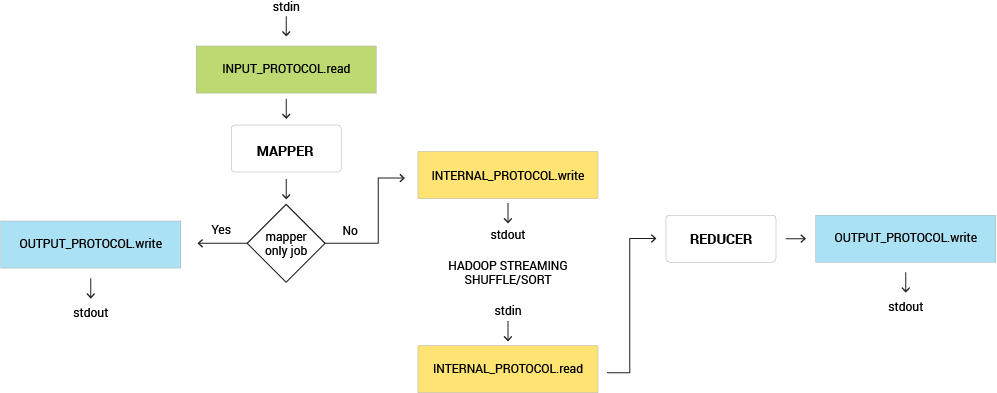

In [119]:
Image("protocols-io-3.png")

<em>Figure 4. Protocols diagram</em>

<h3><a name="MRJob-Protocols-role">III.B.1 Types of Built-in Protocols</a></h3>
<a href="#top">Back to top</a> | <a href="#Section3">Back to Section 3</a>  


MRJob provides a number of built-in protocols, all of which can all be used for INPUT_PROTOCOL, INTERNAL_PROTOCOL or OUTPUT_PROTOCOL. By default, MRJob uses RawValueProtocol for INPUT_PROTOCOL, and JSONProtocol for INTERNAL_PROTOCOL and OUTPUT_PROTOCOL.   

The table below lists four commonly used Protocols and their signature. Some key observations are:

1. RawProtocol and RawValueProtocol do not attempt to serialize and deserialize text data
2. JSONProtocol and JSONValueProtocol uses the JSON encoder and decoder to convert between text (stdin/stdout) and python data structrues (python runtime)
3. Value Protocols always treat key as `None` and do not auto insert a tab character in their write method

<main>
<div style="margin:20px 0;">
  
  <input class="tab-state" id="tab10" type="radio" name="protocols" checked>
  <label for="tab10">RawProtocol</label>
    
  <input class="tab-state" id="tab11" type="radio" name="protocols">
  <label for="tab11">RawValueProtocol</label>
    
  <input class="tab-state" id="tab12" type="radio" name="protocols">
  <label for="tab12">JSONProtocol</label>
  
  <input class="tab-state" id="tab13" type="radio" name="protocols">
  <label for="tab13">JSONValueProtocol</label>
    
  <section id="content10" class="tab">
      <table class="padded-table">
      <tr>
        <td colspan="4" style="background:#fff; vertical-align:middle;" width="50%">read</td>
        <td colspan="4" style="background:#fff; vertical-align:middle;" width="50%">write</td>
      </tr>
      <tr>
        <td colspan="2" class="color-start" width="25%"><strong>Source:</strong>  stdin</td>
        <td colspan="2" class="color-middle" width="25%"><strong>Target:</strong> python</td>
        <td colspan="2" class="color-middle" width="25%"><strong>Source:</strong> python</td>
        <td colspan="2" class="color-end" width="25%"><strong>Target:</strong> stdout</td>
      </tr>
      <tr>
        <td colspan="2" ><strong>Type:</strong> Text</td>
        <td colspan="2" ><strong>Type:</strong> <span style="color: #008000">tuple</span>( <span style="color: #008000">str</span>, <span style="color: #008000">str</span> )</td>
        <td colspan="2" ><strong>Type:</strong> <span style="color: #008000">tuple</span>( <span style="color: #008000">str</span>, <span style="color: #008000">str</span> )</td>
        <td colspan="2" ><strong>Type:</strong> Text</td>
      </tr>
      <tr>
        <td colspan="2"><strong>Shape:</strong> { Key }  [TAB]  { Value }</td>
        <td colspan="2"><strong>Shape:</strong> ( { Key }, { Value } )</td>
        <td colspan="2"><strong>Shape:</strong> ( { Key }, { Value } )</td>
        <td colspan="2"><strong>Shape:</strong> { Key }  [TAB]  { Value }</td>
      </tr>
      <tr>
        <td colspan="8" style="height:40px;vertical-align:bottom;"><strong>EXAMPLES</strong></td>
      </tr>
      <tr>
        <td colspan="4">word    <span style="color: #666666">12</span>  <span style="border: 1px solid #FF0000">⟶</span>  ( <span style="color: #BA2121">&quot;word&quot;</span>, <span style="color: #BA2121">&quot;12&quot;</span> )</td>
        <td colspan="4"><span style="color: #008000; font-weight: bold">yield</span> ( <span style="color: #BA2121">&quot;word&quot;</span>, <span style="color: #BA2121">&quot;12&quot;</span> )  <span style="border: 1px solid #FF0000">⟶</span>  word    <span style="color: #666666">12</span></td>
      </tr>
      <tr>
        <td colspan="4">line_with_no_tab  <span style="border: 1px solid #FF0000">⟶</span>  <span style="color:red">raise ValueError</span></td>
        <td colspan="4"><span style="color: #008000; font-weight: bold">yield</span> ( <span style="color: #BA2121">&quot;a</span><span style="color: #BB6622; font-weight: bold">\t</span><span style="color: #BA2121">b&quot;</span>, <span style="color: #BA2121">&quot;value&quot;</span> )  <span style="border: 1px solid #FF0000">⟶</span>  a     b    value</td>
      </tr>
      
      </table>
  </section>  
  <section id="content11" class="tab">
      <table class="padded-table">
      
      <tr>
        <td colspan="4" style="background:#fff; vertical-align:middle;"width="50%">read</td>
        <td colspan="4" style="background:#fff; vertical-align:middle;"width="50%">write</td>
      </tr>

      <tr>
        <td colspan="2" class="color-start" width="25%"><strong>Source:</strong> stdin</td>
        <td colspan="2" class="color-middle" width="25%"><strong>Target:</strong> python</td>
        <td colspan="2" class="color-middle" width="25%"><strong>Source:</strong> python</td>
        <td colspan="2" class="color-end" width="25%"><strong>Target:</strong> stdout</td>
      </tr>
      <tr>
        <td colspan="2"><strong>Type:</strong> Text</td>
        <td colspan="2"><strong>Type:</strong> <span style="color: #008000">tuple</span>( <span style="color: #008000">None</span>, <span style="color: #008000">str</span> )</td>
        <td colspan="2"><strong>Type:</strong> <span style="color: #008000">tuple</span>( <span style="color: #666666">\*</span>, <span style="color: #008000">str</span> )
</td>
        <td colspan="2"><strong>Type:</strong> Text</td>
      </tr>
      <tr>
        <td colspan="2"><strong>Shape:</strong> { Value }</td>
        <td colspan="2"><strong>Shape:</strong> ( None, { Value } )</td>
        <td colspan="2"><strong>Shape:</strong> ( { }, { Value } )</td>
        <td colspan="2"><strong>Shape:</strong> { Value }</td>
      </tr>
      <tr>
        <td colspan="8" style="height:40px;vertical-align:bottom;"><strong>EXAMPLES</strong></td>
      </tr>
      <tr>
        <td colspan="4">word    <span style="color: #666666">12</span>  <span style="border: 1px solid #FF0000">⟶</span>  ( <span style="color: #008000">None</span>, <span style="color: #BA2121">&quot;word</span><span style="color: #BB6622; font-weight: bold">\t</span><span style="color: #BA2121">12&quot;</span> )</td>
        <td colspan="4"><span style="color: #008000; font-weight: bold">yield</span> ( <span style="color: #BA2121">&quot;word&quot;</span>, <span style="color: #BA2121">&quot;12&quot;</span> )  <span style="border: 1px solid #FF0000">⟶</span>  <span style="color: #666666">12</span> <span style="color:#ff0055;padding-left:20px;">\*</span><span style="color:#777777;">(*see footnote*)</span></td>
      </tr>
      <tr>
        <td colspan="4">line_with_no_tab  <span style="border: 1px solid #FF0000">⟶</span>  ( <span style="color: #008000">None</span>, <span style="color: #BA2121">&quot;line_with_no_tab&quot;</span> )</td>
        <td colspan="4"><span style="color: #008000; font-weight: bold">yield</span> ( <span style="color: #008000">None</span>, <span style="color: #BA2121">&quot;a</span><span style="color: #BB6622; font-weight: bold">\t</span><span style="color: #BA2121">b&quot;</span> )  <span style="border: 1px solid #FF0000">⟶</span>  a    b</td>
      </tr>
      <caption align="bottom"><span style="color:#ff0055;">\*</span> "word" will be ommitted</caption>
      </table>
  </section> 
  <section id="content12" class="tab">
      <table class="padded-table">
          <tr>
            <td colspan="4" style="background:#fff; vertical-align:middle;" width="50%">read</td>
            <td colspan="4" style="background:#fff; vertical-align:middle;" width="50%">write</td>
          </tr>
          <tr>
            <td colspan="2" class="color-start" width="25%"><strong>Source:</strong> stdin</td>
            <td colspan="2" class="color-middle" width="25%"><strong>Target:</strong> python</td>
            <td colspan="2" class="color-middle" width="25%"><strong>Source:</strong> python</td>
            <td colspan="2" class="color-end" width="25%"><strong>Target:</strong> stdout</td>
          </tr>
          <tr>
            <td colspan="2"><strong>Type:</strong> Text</td>
            <td colspan="2"><strong>Type:</strong> <span style="color: #008000">tuple</span>( <span style="color: #666666">\*</span>, <span style="color: #666666">\*</span> )</td>
            <td colspan="2"><strong>Type:</strong> <span style="color: #008000">tuple</span>( <span style="color: #666666">\*</span>, <span style="color: #666666">\*</span> )</td>
            <td colspan="2"><strong>Type:</strong> Text</td>
          </tr>
          <tr>
            <td colspan="2"><strong>Shape:</strong> { Key } [TAB] { Value }</td>
            <td colspan="2"><strong>Shape:</strong> ( { Key }, { Value } )</td>
            <td colspan="2"><strong>Shape:</strong> ( { Key }, { Value } )</td>
            <td colspan="2"><strong>Shape:</strong> { Key }  [TAB]  { Value }</td>
          </tr>
          <tr>
            <td colspan="8" style="height:40px;vertical-align:bottom;"><strong>EXAMPLES</strong></td>
          </tr>
          <tr>
            <td colspan="4"><span style="color: #666666">10</span>    [ <span style="color: #666666">1</span>, true, null, <span style="color: #BA2121">&quot;abc&quot;</span> ]    <span style="border: 1px solid #FF0000">⟶</span>    (<span style="color: #666666">10</span>, [ <span style="color: #666666">1</span>, <span style="color: #008000">True</span>, <span style="color: #008000">None</span>, <span style="color: #BA2121">&quot;abc&quot;</span> ] )</td>
            <td colspan="4"><span style="color: #008000; font-weight: bold">yield</span> ( [ <span style="color: #666666">1</span>, <span style="color: #666666">2</span> ], [ [ <span style="color: #666666">1</span>, <span style="color: #BA2121">&quot;3&quot;</span> ] ] )  <span style="border: 1px solid #FF0000">⟶</span> [ <span style="color: #666666">1</span>, <span style="color: #666666">2</span> ]    [ [<span style="color: #666666">1</span>, <span style="color: #BA2121">&quot;3&quot;</span>] ]</td>
          </tr>
          <tr>
            <td colspan="4">line_with_no_tab    <span style="border: 1px solid #FF0000">⟶</span>    <span style="color:red">raise ValueError</span></td>
            <td colspan="4"><span style="color: #008000; font-weight: bold">yield</span> <span style="color: #666666">1</span>, <span style="color: #666666">2</span>  <span style="border: 1px solid #FF0000">⟶</span>  <span style="color: #666666">1</span>    <span style="color: #666666">2</span></td>
          </tr>
      </table>
  </section> 
  <section id="content13" class="tab">
      <table class="padded-table">
          <tr>
            <td colspan="4" style="background:#fff; vertical-align:middle;" width="50%">read</td>
            <td colspan="4" style="background:#fff; vertical-align:middle;"width="50%">write</td>
          </tr>
          <tr>
            <td colspan="2" class="color-start" width="25%"><strong>Source:</strong> stdin</td>
            <td colspan="2" class="color-middle" width="25%"><strong>Target:</strong> python</td>
            <td colspan="2" class="color-middle" width="25%"><strong>Source:</strong> python</td>
            <td colspan="2" class="color-end" width="25%"><strong>Target:</strong> stdout</td>
          </tr>
          <tr>
            <td colspan="2"><strong>Type:</strong> Text</td>
            <td colspan="2"><strong>Type:</strong> <span style="color: #008000">tuple</span>( <span style="color: #666666">\*</span>, <span style="color: #666666">\*</span> )</td>
            <td colspan="2"><strong>Type:</strong> <span style="color: #008000">tuple</span>( <span style="color: #666666">\*</span>, <span style="color: #666666">\*</span> )
            </td>
            <td colspan="2"><strong>Type:</strong> Text</td>
          </tr>
          <tr>
            <td colspan="2"><strong>Shape:</strong> { Value }</td>
            <td colspan="2"><strong>Shape:</strong> ( <span style="color: #008000">None</span>, { Value } )
            </td>
            <td colspan="2"><strong>Shape:</strong> ( { }, { Value } )</td>
            <td colspan="2"><strong>Shape:</strong> { Value }
            </td>
          </tr>
          <tr>
            <td colspan="8" style="height:40px;vertical-align:bottom;"><strong>EXAMPLES</strong></td>
          </tr>
          <tr>
            <td colspan="4"><span style="color: #666666">10</span>    [ <span style="color: #666666">1</span>, true, null, <span style="color: #BA2121">&quot;abc&quot;</span> ] <span style="border: 1px solid #FF0000">⟶</span> <span style="color:red">raise ValueError</span></td>
            <td colspan="4"><!-- HTML generated using hilite.me --><span style="color: #008000; font-weight: bold">yield</span> ( <span style="color: #666666">1</span>, { <span style="color: #666666">2</span> : <span style="color: #666666">3</span> } )  <span style="border: 1px solid #FF0000">⟶</span>  { <span style="color: #BA2121">&quot;2&quot;</span> : <span style="color: #666666">3</span> }
</td>
          </tr>
          <tr>
            <td colspan="4">
            <!-- HTML generated using hilite.me -->{ <span style="color: #BA2121">&quot;value&quot;</span>: { <span style="color: #BA2121">&quot;nested&quot;</span>: [ <span style="color: #666666">1</span> ] } } <span style="border: 1px solid #FF0000">⟶</span> ( <span style="color: #008000">None</span>, { <span style="color: #BA2121">&quot;value&quot;</span>: { <span style="color: #BA2121">&quot;nested&quot;</span>: [ <span style="color: #666666">1</span> ] } } )
            </td>
            <td colspan="4"><!-- HTML generated using hilite.me --><span style="color: #008000; font-weight: bold">yield</span> ( [<span style="color: #666666">1</span>, <span style="color: #666666">2</span>, <span style="color: #666666">3</span> ], { <span style="color: #BA2121">&quot;value&quot;</span> : <span style="color: #666666">10</span> } ) <span style="border: 1px solid #FF0000">⟶</span>  { <span style="color: #BA2121">&quot;value&quot;</span> : <span style="color: #666666">10</span> }

            </td>
          </tr>
      </table>
  </section> 
</div>
</main>

The following example further illustrates the behaviors of these protocols: a single line of text input (single line text file containing: 1001 {"value":10}) is fed to four different single step MapReduce jobs. Each uses one of the four Protocols discussed above as INPUT_PROTOCOL, INTERNAL_PROTOCOL and OUTPUT_PROTOCOL.


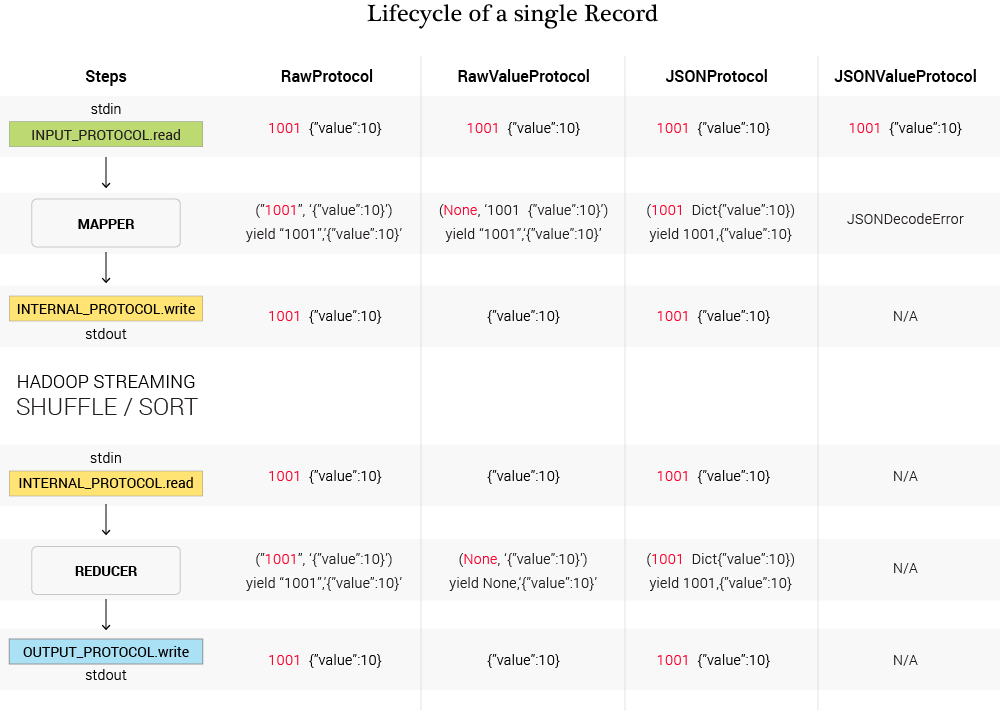

In [105]:
Image("record-lifecyle-2.png")

<em>Figure 5. Lifecycle of a single record.</em>

Corresponding protocols code examples:


<main>
  <input class="tab-state" id="tab_protocol_1" type="radio" name="protocols" checked>
  <label for="tab_protocol_1">RawProtocol</label>
  <input class="tab-state" id="tab_protocol_2" type="radio" name="protocols">
  <label for="tab_protocol_2">RawValueProtocol</label>
  <input class="tab-state" id="tab_protocol_3" type="radio" name="protocols">
  <label for="tab_protocol_3">JSONProtocol</label>
    <input class="tab-state" id="tab_protocol_4" type="radio" name="protocols">
  <label for="tab_protocol_4">JSONValueProtocol</label>
  
  <section id="content_protocol_1" class="tab">
<!-- tab 1 -->
<pre style='color:#000000;background:#ffffff;'><span style='color:#696969; '># raw_protocol.py</span>

<span style='color:#800000; font-weight:bold; '>from</span> mrjob<span style='color:#808030; '>.</span>job <span style='color:#800000; font-weight:bold; '>import</span> MRJob
<span style='color:#800000; font-weight:bold; '>from</span> mrjob<span style='color:#808030; '>.</span>protocol <span style='color:#800000; font-weight:bold; '>import</span> RawProtocol

<span style='color:#800000; font-weight:bold; '>class</span> RawProtocolExample<span style='color:#808030; '>(</span>MRJob<span style='color:#808030; '>)</span><span style='color:#808030; '>:</span>
  
    INPUT_PROTOCOL <span style='color:#808030; '>=</span> RawProtocol
    OUTPUT_PROTOCOL <span style='color:#808030; '>=</span> RawProtocol
    INTERNAL_PROTOCOL <span style='color:#808030; '>=</span> RawProtocol
    
    <span style='color:#800000; font-weight:bold; '>def</span> mapper<span style='color:#808030; '>(</span>self<span style='color:#808030; '>,</span> key<span style='color:#808030; '>,</span> value<span style='color:#808030; '>)</span><span style='color:#808030; '>:</span>
        <span style='color:#800000; font-weight:bold; '>assert</span> key <span style='color:#44aadd; '>==</span> <span style='color:#0000e6; '>"1001"</span>
        <span style='color:#800000; font-weight:bold; '>assert</span> value <span style='color:#44aadd; '>==</span> <span style='color:#0000e6; '>"{</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>value</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>:10}"</span>
        <span style='color:#800000; font-weight:bold; '>yield</span> <span style='color:#0000e6; '>"1001"</span><span style='color:#808030; '>,</span> <span style='color:#0000e6; '>"{</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>value</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>:10}"</span>
    <span style='color:#800000; font-weight:bold; '>def</span> reducer<span style='color:#808030; '>(</span>self<span style='color:#808030; '>,</span> key<span style='color:#808030; '>,</span> values<span style='color:#808030; '>)</span><span style='color:#808030; '>:</span>
        <span style='color:#800000; font-weight:bold; '>for</span> value <span style='color:#800000; font-weight:bold; '>in</span> values<span style='color:#808030; '>:</span>
            <span style='color:#800000; font-weight:bold; '>assert</span> key <span style='color:#44aadd; '>==</span> <span style='color:#0000e6; '>"1001"</span>
            <span style='color:#800000; font-weight:bold; '>assert</span> value <span style='color:#44aadd; '>==</span> <span style='color:#0000e6; '>"{</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>value</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>:10}"</span>
            <span style='color:#800000; font-weight:bold; '>yield</span> <span style='color:#0000e6; '>"1001"</span><span style='color:#808030; '>,</span> <span style='color:#0000e6; '>"{</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>value</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>:10}"</span>

<span style='color:#800000; font-weight:bold; '>if</span> <span style='color:#074726; '>__name__</span> <span style='color:#44aadd; '>==</span> <span style='color:#0000e6; '>'__main__'</span><span style='color:#808030; '>:</span>
    RawProtocolExample<span style='color:#808030; '>.</span>run<span style='color:#808030; '>(</span><span style='color:#808030; '>)</span>
</pre>
<pre style='color:#000000;background:#ffffff;margin-top:-1px'>
<code>echo '1001\t{"value":10}' | python raw_protocol.py</code>
</pre>
<pre style>
<code style="color:#888;margin:0;">
Creating temp directory /tmp/raw_protocol.yiran.20160828.061913.768951
Running step 1 of 1...
reading from STDIN
Streaming final output from /tmp/raw_protocol.yiran.20160828.061913.768951/output...
</code>
1001	{"value":10}
<code style="color:#888;margin:0;">
Removing temp directory /tmp/raw_protocol.yiran.20160828.061913.768951...
</code>
</pre>
  </section>
  <section id="content_protocol_2" class="tab">
<pre style='color:#000000;background:#ffffff;'><span style='color:#696969; '># raw_value_protocol.py</span>

<span style='color:#800000; font-weight:bold; '>from</span> mrjob<span style='color:#808030; '>.</span>job <span style='color:#800000; font-weight:bold; '>import</span> MRJob
<span style='color:#800000; font-weight:bold; '>from</span> mrjob<span style='color:#808030; '>.</span>protocol <span style='color:#800000; font-weight:bold; '>import</span> RawValueProtocol

<span style='color:#800000; font-weight:bold; '>class</span> RawValueProtocolExample<span style='color:#808030; '>(</span>MRJob<span style='color:#808030; '>)</span><span style='color:#808030; '>:</span>
  
    INPUT_PROTOCOL <span style='color:#808030; '>=</span> RawValueProtocol
    OUTPUT_PROTOCOL <span style='color:#808030; '>=</span> RawValueProtocol
    INTERNAL_PROTOCOL <span style='color:#808030; '>=</span> RawValueProtocol
    
    <span style='color:#800000; font-weight:bold; '>def</span> mapper<span style='color:#808030; '>(</span>self<span style='color:#808030; '>,</span> key<span style='color:#808030; '>,</span> value<span style='color:#808030; '>)</span><span style='color:#808030; '>:</span>
        <span style='color:#800000; font-weight:bold; '>assert</span> key <span style='color:#44aadd; '>==</span> <span style='color:#074726; '>None</span>
        <span style='color:#800000; font-weight:bold; '>assert</span> value <span style='color:#44aadd; '>==</span> <span style='color:#0000e6; '>"1001</span><span style='color:#0f69ff; '>\t</span><span style='color:#0000e6; '>{</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>value</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>:10}"</span>
        <span style='color:#800000; font-weight:bold; '>yield</span> <span style='color:#0000e6; '>"1001"</span><span style='color:#808030; '>,</span> <span style='color:#0000e6; '>"{</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>value</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>:10}"</span>
    <span style='color:#800000; font-weight:bold; '>def</span> reducer<span style='color:#808030; '>(</span>self<span style='color:#808030; '>,</span> key<span style='color:#808030; '>,</span> values<span style='color:#808030; '>)</span><span style='color:#808030; '>:</span>
        <span style='color:#800000; font-weight:bold; '>for</span> value <span style='color:#800000; font-weight:bold; '>in</span> values<span style='color:#808030; '>:</span>
            <span style='color:#800000; font-weight:bold; '>assert</span> key <span style='color:#44aadd; '>==</span> <span style='color:#074726; '>None</span>
            <span style='color:#800000; font-weight:bold; '>assert</span> value <span style='color:#44aadd; '>==</span> <span style='color:#0000e6; '>"{</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>value</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>:10}"</span>
            <span style='color:#800000; font-weight:bold; '>yield</span> <span style='color:#074726; '>None</span><span style='color:#808030; '>,</span> <span style='color:#0000e6; '>"{</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>value</span><span style='color:#0f69ff; '>\"</span><span style='color:#0000e6; '>:10}"</span>

<span style='color:#800000; font-weight:bold; '>if</span> <span style='color:#074726; '>__name__</span> <span style='color:#44aadd; '>==</span> <span style='color:#0000e6; '>'__main__'</span><span style='color:#808030; '>:</span>
    RawValueProtocolExample<span style='color:#808030; '>.</span>run<span style='color:#808030; '>(</span><span style='color:#808030; '>)</span>
</pre>
<pre style='color:#000000;background:#ffffff;'>
<code>echo '1001\t{"value":10}' | python raw_value_protocol.py</code>
</pre>
<pre style>
<code style="color:#888;margin:0;">
Creating temp directory /tmp/raw_protocol.yiran.20160828.061913.768951
Running step 1 of 1...
reading from STDIN
Streaming final output from /tmp/raw_protocol.yiran.20160828.061913.768951/output...
</code>
{"value":10}
<code style="color:#888;margin:0;">
Removing temp directory /tmp/raw_protocol.yiran.20160828.061913.768951...
</code>
</pre>
  </section>
  <section id="content_protocol_3" class="tab">
<pre style='color:#000000;background:#ffffff;'><span style='color:#696969; '># json_protocol.py</span>

<span style='color:#800000; font-weight:bold; '>from</span> mrjob<span style='color:#808030; '>.</span>job <span style='color:#800000; font-weight:bold; '>import</span> MRJob
<span style='color:#800000; font-weight:bold; '>from</span> mrjob<span style='color:#808030; '>.</span>protocol <span style='color:#800000; font-weight:bold; '>import</span> JSONProtocol

<span style='color:#800000; font-weight:bold; '>class</span> JSONProtocolExample<span style='color:#808030; '>(</span>MRJob<span style='color:#808030; '>)</span><span style='color:#808030; '>:</span>
  
    INPUT_PROTOCOL <span style='color:#808030; '>=</span> JSONProtocol
    OUTPUT_PROTOCOL <span style='color:#808030; '>=</span> JSONProtocol
    INTERNAL_PROTOCOL <span style='color:#808030; '>=</span> JSONProtocol
    
    <span style='color:#800000; font-weight:bold; '>def</span> mapper<span style='color:#808030; '>(</span>self<span style='color:#808030; '>,</span> key<span style='color:#808030; '>,</span> value<span style='color:#808030; '>)</span><span style='color:#808030; '>:</span>
        <span style='color:#800000; font-weight:bold; '>assert</span> key <span style='color:#44aadd; '>==</span> <span style='color:#008c00; '>1001</span>
        <span style='color:#800000; font-weight:bold; '>assert</span> value <span style='color:#44aadd; '>==</span> <span style='color:#800080; '>{</span><span style='color:#0000e6; '>"value"</span><span style='color:#808030; '>:</span><span style='color:#008c00; '>10</span><span style='color:#800080; '>}</span>
        <span style='color:#800000; font-weight:bold; '>assert</span> <span style='color:#400000; '>isinstance</span><span style='color:#808030; '>(</span>value<span style='color:#808030; '>,</span> <span style='color:#400000; '>dict</span><span style='color:#808030; '>)</span>
        <span style='color:#800000; font-weight:bold; '>yield</span> key<span style='color:#808030; '>,</span> value
    <span style='color:#800000; font-weight:bold; '>def</span> reducer<span style='color:#808030; '>(</span>self<span style='color:#808030; '>,</span> key<span style='color:#808030; '>,</span> values<span style='color:#808030; '>)</span><span style='color:#808030; '>:</span>
        <span style='color:#800000; font-weight:bold; '>for</span> value <span style='color:#800000; font-weight:bold; '>in</span> values<span style='color:#808030; '>:</span>
            <span style='color:#800000; font-weight:bold; '>assert</span> key <span style='color:#44aadd; '>==</span> <span style='color:#008c00; '>1001</span>
            <span style='color:#800000; font-weight:bold; '>assert</span> value <span style='color:#44aadd; '>==</span> <span style='color:#800080; '>{</span><span style='color:#0000e6; '>"value"</span><span style='color:#808030; '>:</span><span style='color:#008c00; '>10</span><span style='color:#800080; '>}</span>
            <span style='color:#800000; font-weight:bold; '>yield</span> key<span style='color:#808030; '>,</span> value

<span style='color:#800000; font-weight:bold; '>if</span> <span style='color:#074726; '>__name__</span> <span style='color:#44aadd; '>==</span> <span style='color:#0000e6; '>'__main__'</span><span style='color:#808030; '>:</span>
    JSONProtocolExample<span style='color:#808030; '>.</span>run<span style='color:#808030; '>(</span><span style='color:#808030; '>)</span>
</pre>
<pre style='color:#000000;background:#ffffff;'>
<code>echo '1001\t{"value":10}' | python json_protocol.py</code>
</pre>
<pre style>
<code style="color:#888;margin:0;">
Creating temp directory /tmp/raw_protocol.yiran.20160828.061913.768951
Running step 1 of 1...
reading from STDIN
Streaming final output from /tmp/raw_protocol.yiran.20160828.061913.768951/output...
</code>
1001	{"value":10}
<code style="color:#888;margin:0;">
Removing temp directory /tmp/raw_protocol.yiran.20160828.061913.768951...
</code>
</pre>
  </section>
  <section id="content_protocol_4" class="tab">
  <pre style='color:#000000;background:#ffffff;'><span style='color:#696969; '># json_value_protocol.py</span>

<span style='color:#800000; font-weight:bold; '>from</span> mrjob<span style='color:#808030; '>.</span>job <span style='color:#800000; font-weight:bold; '>import</span> MRJob
<span style='color:#800000; font-weight:bold; '>from</span> mrjob<span style='color:#808030; '>.</span>protocol <span style='color:#800000; font-weight:bold; '>import</span> JSONValueProtocol

<span style='color:#800000; font-weight:bold; '>class</span> JSONValueProtocolExample<span style='color:#808030; '>(</span>MRJob<span style='color:#808030; '>)</span><span style='color:#808030; '>:</span>
  
    INPUT_PROTOCOL <span style='color:#808030; '>=</span> JSONValueProtocol
    OUTPUT_PROTOCOL <span style='color:#808030; '>=</span> JSONValueProtocol
    INTERNAL_PROTOCOL <span style='color:#808030; '>=</span> JSONValueProtocol
    
    <span style='color:#800000; font-weight:bold; '>def</span> mapper<span style='color:#808030; '>(</span>self<span style='color:#808030; '>,</span> key<span style='color:#808030; '>,</span> value<span style='color:#808030; '>)</span><span style='color:#808030; '>:</span>
        <span style='color:#800000; font-weight:bold; '>pass</span>
    <span style='color:#800000; font-weight:bold; '>def</span> reducer<span style='color:#808030; '>(</span>self<span style='color:#808030; '>,</span> key<span style='color:#808030; '>,</span> values<span style='color:#808030; '>)</span><span style='color:#808030; '>:</span>
        <span style='color:#800000; font-weight:bold; '>pass</span>

<span style='color:#800000; font-weight:bold; '>if</span> <span style='color:#074726; '>__name__</span> <span style='color:#44aadd; '>==</span> <span style='color:#0000e6; '>'__main__'</span><span style='color:#808030; '>:</span>
    JSONValueProtocolExample<span style='color:#808030; '>.</span>run<span style='color:#808030; '>(</span><span style='color:#808030; '>)</span>
</pre>
<pre style='color:#000000;background:#ffffff;'>
<code>echo '1001\t{"value":10}' | python json_value_protocol.py</code>
</pre>
<pre style>
<code style="color:#888;margin:0;">
Creating temp directory /tmp/json_value_protocol.yiran.20160914.050922.301542
Running step 1 of 1...
reading from STDIN
Traceback (most recent call last):
  File "json_value_protocol.py", line 17, in <module>
    JSONValueProtocolExample.run()
  File "/home/yiran/anaconda/lib/python2.7/site-packages/mrjob/job.py", line 433, in run
    mr_job.execute()
  File "/home/yiran/anaconda/lib/python2.7/site-packages/mrjob/job.py", line 451, in execute
    super(MRJob, self).execute()
  ...
    key, value = read(line.rstrip(b'\r\n'))
  File "/home/yiran/anaconda/lib/python2.7/site-packages/mrjob/protocol.py", line 222, in read
    return (None, ujson.loads(line))
ValueError: Trailing data
</code>
</pre>
  </section>
</main>

<h3><a name="Importance-of-RawProtocols">III.B.2 Importance of RawProtocols in Context of Total Sorting</a></h3>
<a href="#top">Back to top</a> | <a href="#Section3">Back to Section 3</a>  

While working with MRJob, it is critical to understand that MRJob is an abstraction layer above Hadoop Streaming, and does not extend or modify Hadoop Streaming's normal behaviors. Hadoop streaming works through Unix piping, and uses stdout and stderr as communication channels. In Unix environments, the protocol of data transfer is text streams – mappers, reducers and Hadoop libraries exchange data through text.   

Therefore, data structures common in programming languages (e.g. dictionary in Python ) have to be serialized to text for Hadoop Streaming to understand and consume. The implication of this on total sorting is this: since Hadoop only sees text, custom data structures (as keys) will be sorted as strings in their serialized forms.    

MRJob abstracts away the data serialization and deserialization processes by the concept of protocols. For instance, JSONProtocol is capable of serializing complex data structures, and is used by default as INTERNAL_PROTOCOL. This frees the user from messy string manipulation and processing, but it does come with a cost.


One example is python tuples:

```
# mapper
yield 1, ("value", "as", "tuple", True)

```

Inside the reducer however, when values are deserialized into python objects, the (key, value) pair above will become:
```
1, ["value", "as", "tuple", True]

```

Namely, tuples become lists, due to the fact JSON does not support tuples. 

Another example related to sorting: suppose mappers emit custom data structures as composite keys, such as:
```
# mapper
yield [12, 1, 2016]
```

Assuming we want to use hadoop streaming's KeyFieldBasedComparator, when hadoop streaming sees the JSON string [2016, 12, 1], it is very difficult to instruct hadoop to understand the key consists of three fields (month, day, year), and sort them accordingly (e.g. we want sort by year, month, day).   

Notice if we yield a date as [2016, 12, 01] instead, the string comparison coincidentally produces the same sort order as the underlying data (dates). However, to achieve this requires intimate knowledge of JSON (or other transportation formats); therefore, we recommend using RawProtocol or RawValueProtocol when advanced sorting is desired, which offers maximum flexibility to control key sorting and key hashing performed by Hadoop Streaming.


<h2><a name="MRJob-partitioning">III.C. Partitioning in MRJob</a></h2>
<a href="#top">Back to top</a>   | <a href="#Section3">Back to Section 3</a>

<h4>Keypoints:</h4>

<ul>
<li>Challenge: which partition contains the largest/smallest values seems arbitrary</li>
<li>Hadoop streaming `KeyFieldBasedPartitioner` does not sort partition keys, even though it seemingly accepts Unix `sort` compatible configurations</li>
<li>MRJob uses Hadoop Streaming under the hood, therefore inherits the same problem</li>
</ul>

<h4>Solution:</h4>

<ul>
<li>Understand the inner working of `HashPartitioner` and `KeyFieldBasedPartitioner`</li>
<li>Relationship between `KeyFieldBasedPartitioner` and `HashPartitioner`:   

  * `KeyFieldBasedPartitioner` applies `HashPartitioner` on configured key field(s)</li>
  
<li>Create the inverse function of `HashPartitioner` and assign partition keys accordingly</li>
</ul>

<h3><a name="Understanding-HashPartitioner"> Understanding HashPartitioner</a></h3>
<a href="#top">Back to top</a>   | <a href="#Section3">Back to Section 3</a>

By default, Hadoop uses a library class `HashPartitioner` to compute the partition index for keys produced by mappers. It has a method called `getPartition`, which takes `key.hashCode() & Integer.MAX_VALUE` and finds the modulus using the number of reduce tasks. For example, if there are 10 reduce tasks, `getPartition` will return values 0 through 9 for all keys.

```
// HashPartitioner

partitionIndex = (key.hashCode() & Integer.MAX_VALUE) % numReducers
```

In the land of native hadoop applications (written in Java or JVM languages), keys can be any object type that is hashable (i.e. implements hashable interface). For Hadoop Streaming, however, keys are always string values. Therefore the hashCode function for strings is used:

<!-- HTML generated using hilite.me -->
<div style="margin:20px 0;background: #f8f8f8; overflow:auto;width:auto;border:0;border-width:.0;padding:.0;"><pre style="margin: 0; line-height: 125%">public <span style="color: #008000">int</span> hashCode() {
    <span style="color: #008000">int</span> h <span style="color: #666666">=</span> <span style="color: #008000">hash</span>;
    <span style="color: #008000; font-weight: bold">if</span> (h <span style="color: #666666">==</span> <span style="color: #666666">0</span> <span style="color: #666666">&amp;&amp;</span> value<span style="color: #666666">.</span>length <span style="color: #666666">&gt;</span> <span style="color: #666666">0</span>) {
        char val[] <span style="color: #666666">=</span> value;

        <span style="color: #008000; font-weight: bold">for</span> (<span style="color: #008000">int</span> i <span style="color: #666666">=</span> <span style="color: #666666">0</span>; i <span style="color: #666666">&lt;</span> value<span style="color: #666666">.</span>length; i<span style="color: #666666">++</span>) {
            h <span style="color: #666666">=</span> <span style="color: #666666">31</span> <span style="color: #666666">*</span> h <span style="color: #666666">+</span> val[i];
        }
        <span style="color: #008000">hash</span> <span style="color: #666666">=</span> h;
    }
    <span style="color: #008000; font-weight: bold">return</span> h;
}
</pre></div>


When we configure Hadoop Streaming to use KeyBasedPartitioner, the process is very similar. Hadoop Streaming will parse command line options such as -k2,2 into key specs, and extract the part of the composite key (in this example, field 2 of many fields) and read in the partition key as a string. For example, with the following configuration:

```
"stream.map.output.field.separator" : ".",
"mapreduce.partition.keycomparator.options": "-k2,2",
```

Hadoop will extract '<strong>a</strong>' from a composite key <strong>2.a.4</strong> to use as the partition key.

The partition key is then hashed (as string) by the same `hashCode` function, its modulus using number of reduce tasks yields the partition index.

See `KeyBasedPartitioner` [source code](https://github.com/apache/hadoop/blob/2e1d0ff4e901b8313c8d71869735b94ed8bc40a0/hadoop-mapreduce-project/hadoop-mapreduce-client/hadoop-mapreduce-client-core/src/main/java/org/apache/hadoop/mapreduce/lib/partition/KeyFieldBasedPartitioner.java) for the actual implementations.

<h3><a name="Inverse-HashCode-Function">Inverse HashCode Function</a></h3>
<a href="#top">Back to top</a>   | <a href="#Section3">Back to Section 3</a>


In order to preserve partition key ordering, we will construct an "inverse hashCode function", which takes as input the desired partition index and total number of partitions, and returns a partition key. This key, when supplied to the Hadoop framework (KeyBasedPartitioner), will hash to the correct partition index.   

First, let's implement the core of HashPartitioner in Python :


In [117]:
def makeKeyHash(key, num_reducers):
    byteof = lambda char: int(format(ord(char), 'b'), 2)
    current_hash = 0
    for c in key:
        current_hash = (current_hash * 31 + byteof(c))
    return current_hash % num_reducers

# partition indices for keys: A,B,C; with 3 partitions
[makeKeyHash(x, 3) for x in "ABC"]

[2, 0, 1]

A simple strategy to implement an inverse hashCode function is to use a lookup table. For example, assuming we have 3 reducers, we can compute the partition index with makeKeyHash for keys "A", "B", and "C". The results are listed the the table below.

| <strong>Partition Key</strong> | <strong>Partition Index</strong> |
|-------------------|---------------------|
| A                 | 2                   |
| B                 | 0                   |
| C                 | 1                   |


In the mapper stage, if we want to assign a record to partition 0, for example, we can simply look at the partition key that generated the partition index 0, which in this case is "B".


<h2><a name="illustration">Total Order Sort with ordered partitions - illustrated</a></h2>

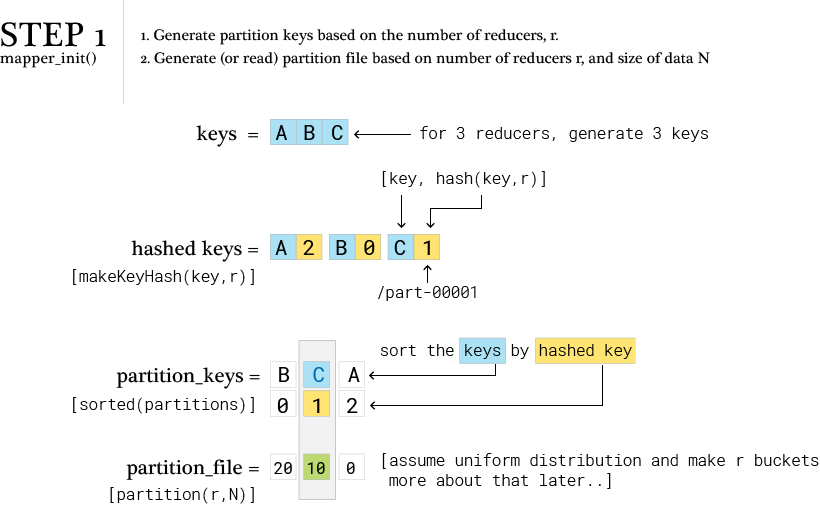

In [107]:
Image(filename="tos-step1.png")

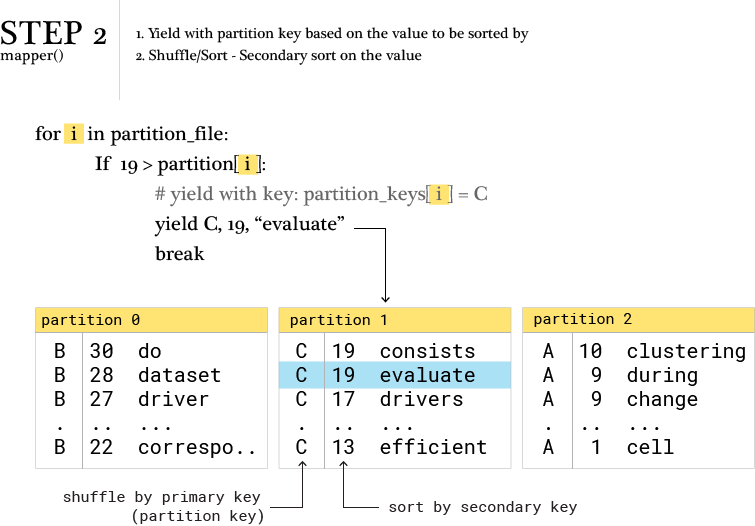

In [110]:
Image(filename="tos-step2.png")

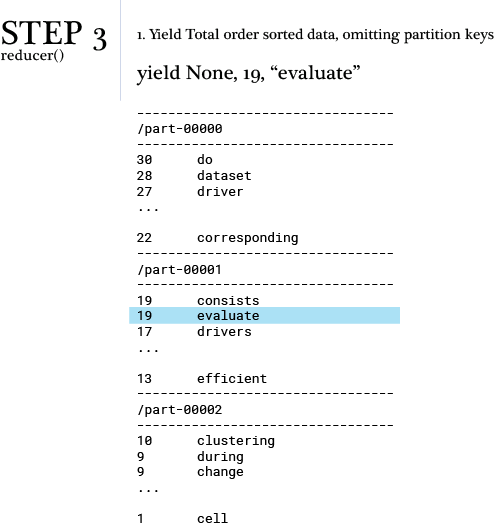

In [111]:
Image(filename="tos-step3.png")

<h2><a name="MRJOB-implementation">III.D. MRJob Implementations</a></h2>
<a href="#top">Back to top</a>  | <a href="#Section3">Back to Section 3</a>  

<h3><a name="III.D.1">III.D.1 MRJob implementation - single reducer - local mode</a></h3>
<a href="#top">Back to top</a>  | <a href="#Section3">Back to Section 3</a>  
(Included only for completeness)

In [152]:
%%writefile singleReducerSortLocal.py

import sys
import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep

class singleReducerSortLocal(MRJob):
        
    def mapper(self, _, line):
        line = line.strip()
        key,value = line.split('\t')
        yield (sys.maxint - int(key)), value

    def reducer(self, key, value):
        for v in value:
            yield sys.maxint - key, v
        
    def steps(self):
        return [MRStep(
                    mapper=self.mapper,
                    reducer=self.reducer)
                ]

if __name__ == '__main__':
    singleReducerSortLocal.run()

Overwriting singleReducerSortLocal.py


In [155]:
!python singleReducerSortLocal.py generate_numbers.output > MRJob_singleReducer_local_sorted_output.txt

In [9]:
print "="*100
print "Single Reducer Local Sorted Output - MRJob"
print "="*100
!cat MRJob_singleReducer_local_sorted_output.txt

Single Reducer Local Sorted Output - MRJob
30	"do"
28	"dataset"
27	"creating"
27	"driver"
27	"experiements"
26	"def"
26	"descent"
25	"compute"
24	"code"
24	"done"
23	"descent"
22	"corresponding"
19	"consists"
19	"evaluate"
17	"drivers"
15	"computational"
15	"computing"
15	"document"
14	"center"
13	"efficient"
10	"clustering"
9	"change"
9	"during"
7	"contour"
5	"distributed"
4	"develop"
3	"different"
2	"cluster"
1	"cell"
0	"current"


<h3><a name="III.D.2">III.D.2. MRJob implementation - single reducer - Hadoop mode</a></h3>
<a href="#top">Back to top</a>  | <a href="#Section3">Back to Section 3</a>  
No need for any special paritioning, but can be a bottle neck when data is large

In [30]:
%%writefile singleReducerSort.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-
import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep

class SingleReducerSort(MRJob):
    # By specifying sort values True, mrjob will do a secondary sort on the value, in this case the words.
    # ties will be broken by sorting words alphabetically in ascending order
    MRJob.SORT_VALUES = True   
    
    def mapper(self, _, line):
        line = line.strip()
        key,value = line.split('\t')
        yield int(key),value

    def reducer(self, key, value):
        for v in value:
            yield key, v
        
    def steps(self):
        JOBCONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.map.output.field.separator':'\t',    
            'mapreduce.partition.keycomparator.options': '-k1,1nr -k2',
            'mapreduce.job.reduces': '1'
        }
        return [MRStep(jobconf=JOBCONF_STEP,
                    mapper=self.mapper,
                    reducer=self.reducer)
                ]

if __name__ == '__main__':
    SingleReducerSort.run()

Overwriting singleReducerSort.py


In [134]:
!python singleReducerSort.py -r hadoop generate_numbers.output > MRJob_singleReducer_sorted_output.txt

In [34]:
print "="*100
print "Single Reducer Sorted Output - MRJob"
print "="*100
!cat MRJob_singleReducer_sorted_output.txt

Single Reducer Sorted Output - MRJob
30	"do"
28	"dataset"
27	"creating"
27	"driver"
27	"experiements"
26	"def"
26	"descent"
25	"compute"
24	"code"
24	"done"
23	"descent"
22	"corresponding"
19	"consists"
19	"evaluate"
17	"drivers"
15	"computational"
15	"computing"
15	"document"
14	"center"
13	"efficient"
10	"clustering"
9	"change"
9	"during"
7	"contour"
5	"distributed"
4	"develop"
3	"different"
2	"cluster"
1	"cell"
0	"current"


<h3><a name="III.D.3">III.D.3. MRJob Multiple Reducers - With Un-Ordered Partitons</a></h3>
<a href="#top">Back to top</a>  | <a href="#Section3">Back to Section 3</a> 

The equivalent of the Hadoop Streaming Total Order Sort implementation above

In [51]:
%%writefile MRJob_unorderedTotalOrderSort.py

import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol
from operator import itemgetter
import numpy as np

class MRJob_unorderedTotalOrderSort(MRJob):
    
    # Allows values to be treated as keys, so they can be used for sorting:
    MRJob.SORT_VALUES = True 
    
    # The protocols are critical. It will not work without these:
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
 
    def __init__(self, *args, **kwargs):
        super(MRJob_unorderedTotalOrderSort, self).__init__(*args, **kwargs)
        self.NUM_REDUCERS = 3
    
    
    def mapper(self, _, line):
        line = line.strip()
        key,value = line.split('\t')
        if int(key) > 20:
            yield "A",key+"\t"+value
        elif int(key) > 10:
            yield "B",key+"\t"+value
        else:
            yield "C",key+"\t"+value
            
    def reducer(self,key,value):
        for v in value:
            yield key, v

    
    def steps(self):
        
        JOBCONF_STEP1 = {
            'stream.num.map.output.key.fields':3,
            'stream.map.output.field.separator':"\t",
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options':'-k1,1 -k2,2nr -k3,3',
            'mapred.reduce.tasks': self.NUM_REDUCERS,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [MRStep(jobconf=JOBCONF_STEP1,
                    mapper=self.mapper,
                    reducer=self.reducer)
                ]

if __name__ == '__main__':
    MRJob_unorderedTotalOrderSort.run()

Overwriting MRJob_unorderedTotalOrderSort.py


In [55]:
!hdfs dfs -rmr /user/koza/sort/un_output 
!python MRJob_unorderedTotalOrderSort.py  -r hadoop generate_numbers.output \
    --output-dir=/user/koza/sort/un_output 

In [36]:
!hdfs dfs -ls /user/koza/sort/un_output 

Found 4 items
-rw-r--r--   1 koza supergroup          0 2016-08-20 19:28 /user/koza/sort/un_output/_SUCCESS
-rw-r--r--   1 koza supergroup        116 2016-08-20 19:28 /user/koza/sort/un_output/part-00000
-rw-r--r--   1 koza supergroup        125 2016-08-20 19:28 /user/koza/sort/un_output/part-00001
-rw-r--r--   1 koza supergroup        152 2016-08-20 19:28 /user/koza/sort/un_output/part-00002


### Without special partitioning, the output is not organized by partition number.
(i.e., part-00000 does not contain the "A" key)

In [54]:
print "----/part-00000-----\n"
!hdfs dfs -cat /user/koza/sort/un_output/part-00000
print "\n----/part-00001-----\n"
!hdfs dfs -cat /user/koza/sort/un_output/part-00001
print "\n----/part-00001-----\n"
!hdfs dfs -cat /user/koza/sort/un_output/part-00002

----/part-00000-----

B	19	consists	
B	19	evaluate	
B	17	drivers	
B	15	computational	
B	15	computing	
B	15	document	
B	14	center	
B	13	efficient	

----/part-00001-----

C	10	clustering	
C	9	change	
C	9	during	
C	7	contour	
C	5	distributed	
C	4	develop	
C	3	different	
C	2	cluster	
C	1	cell	
C	0	current	

----/part-00001-----

A	30	do	
A	28	dataset	
A	27	creating	
A	27	driver	
A	27	experiements	
A	26	def	
A	26	descent	
A	25	compute	
A	24	code	
A	24	done	
A	23	descent	
A	22	corresponding	


<h3><a name="III.D.4">III.D.4. MRJob Multiple Reducers - With Ordered Partitons</a></h3>
<a href="#top">Back to top</a>  | <a href="#Section3">Back to Section 3</a> 

The final Total Order Sort with ordered partitions

<h4>What's New</h4>

The solution we will delve into is very similar to the one discussed earlier in the  [Hadoop Streaming](#multiple-reducer-hadoop-streaming)  section. The only addition is Step 1B, where we take a desired partition index and craft a custom partition key such that Hadoop's KeyFieldBasedPartitioner hashes it back to the correct index.


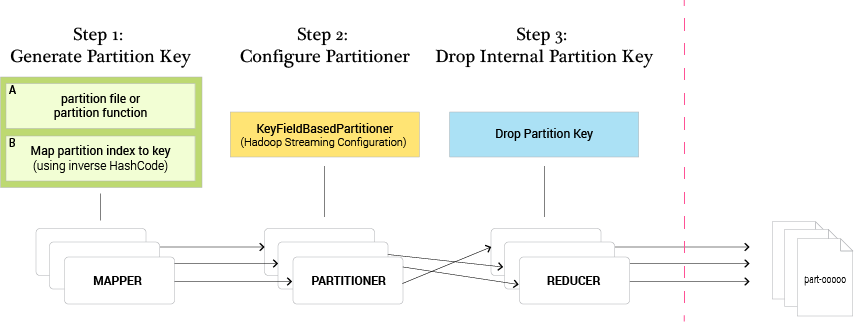

In [96]:
Image("TotalSortStepsComplete.png")

<em>Figure 6. Total order sort with custom partitioning.</em>

In [66]:
%%writefile MRJob_multipleReducerTotalOrderSort.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol
from operator import itemgetter
import numpy as np

class MRJob_multipleReducerTotalOrderSort(MRJob):
    
    # Allows values to be treated as keys
    MRJob.SORT_VALUES = True 
    
    # The protocols are critical. It will not work without these:
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
 
    def __init__(self, *args, **kwargs):
        super(MRJob_multipleReducerTotalOrderSort, self).__init__(*args, **kwargs)
        self.N = 30
        self.NUM_REDUCERS = 3
    
    def mapper_partitioner_init(self):
        
        def makeKeyHash(key, num_reducers):
            byteof = lambda char: int(format(ord(char), 'b'), 2)
            current_hash = 0
            for c in key:
                current_hash = (current_hash * 31 + byteof(c))
            return current_hash % num_reducers
        
        # printable ascii characters, starting with 'A'
        keys = [str(unichr(i)) for i in range(65,65+self.NUM_REDUCERS)]
        partitions = []
        
        for key in keys:
            partitions.append([key, makeKeyHash(key, self.NUM_REDUCERS)])

        parts = sorted(partitions,key=itemgetter(1))
        self.partition_keys = list(np.array(parts)[:,0])
        
        self.partition_file = np.arange(0,self.N,self.N/(self.NUM_REDUCERS))[::-1]
        
    def mapper_partition(self, _, line):
        line = line.strip()
        key,value = line.split('\t')
        
        # Prepend the approriate key by finding the bucket, and using the index to fetch the key.
        for idx in xrange(self.NUM_REDUCERS):
            if float(key) > self.partition_file[idx]:
                yield str(self.partition_keys[idx]),key+"\t"+value
                break
        
        
            
    def reducer(self,key,value):
        for v in value:
            yield key,v
            # To omit the partition key, specify 'None'
            # We are keeping it for illutration purposes
    
    def steps(self):
        
        JOBCONF_STEP1 = {
            'stream.num.map.output.key.fields':3,
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.map.output.field.separator':"\t",
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.partition.keycomparator.options':'-k2,2nr -k3,3',
            'mapred.reduce.tasks': self.NUM_REDUCERS,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [MRStep(jobconf=JOBCONF_STEP1,
                    mapper_init=self.mapper_partitioner_init,
                    mapper=self.mapper_partition,
                    reducer=self.reducer)
                ]


if __name__ == '__main__':
    MRJob_multipleReducerTotalOrderSort.run()

Overwriting MRJob_multipleReducerTotalOrderSort.py


In [69]:
!hdfs dfs -rm -r /user/koza/total_order_sort
!python MRJob_multipleReducerTotalOrderSort.py -r hadoop generate_numbers.output \
    --output-dir='/user/koza/total_order_sort' 

In [68]:
print "="*100
print "Total Order Sort with multiple reducers - notice that the part files are also in order."
print "="*100
print "/part-00000"
print "-"*100
!hdfs dfs -cat /user/koza/total_order_sort/part-00000
print "-"*100
print "/part-00001"
print "-"*100
!hdfs dfs -cat /user/koza/total_order_sort/part-00001
print "-"*100
print "/part-00002"
print "-"*100
!hdfs dfs -cat /user/koza/total_order_sort/part-00002


Total Order Sort with multiple reducers - notice that the part files are also in order.
/part-00000
----------------------------------------------------------------------------------------------------
B	30	do	
B	28	dataset	
B	27	creating	
B	27	driver	
B	27	experiements	
B	26	def	
B	26	descent	
B	25	compute	
B	24	code	
B	24	done	
B	23	descent	
B	22	corresponding	
----------------------------------------------------------------------------------------------------
/part-00001
----------------------------------------------------------------------------------------------------
C	19	consists	
C	19	evaluate	
C	17	drivers	
C	15	computational	
C	15	computing	
C	15	document	
C	14	center	
C	13	efficient	
----------------------------------------------------------------------------------------------------
/part-00002
----------------------------------------------------------------------------------------------------
A	10	clustering	
A	9	change	
A	9	during	
A	7	contour	
A	5	distributed	
A	4	develop	

<a name="illustration"></a>

<h3>Total Order Sort results</h3>
We now have exactly what we were looking for. Total Order Sort, with the added benefit of ordered partitions. Notice that the top results are stored in part-00000, the next set of results is stored in part-00001, etc., because we hashed the keys (A,B,C) to those file names.

<h1><a name="Section4">Section IV - Sampling Key Spaces</a></h1>
<a href="#top">Back to top</a>   

<h4>Keypoints:</h4>
<ul>
<li><a name="randomsampling">Random Sampling</a> - Easy implementation when we know the total size of the data</li>
<li><a name="reservoirsampling">Reservoir Sampling</a> - A method to sample the data with equal probablity for all data points when the size of the data is unknown. The algorithm works as follows:
    <pre>
    n = desired sample size
    reservoir = []
    for d in data
        if reservoir size < n
            add d to reservoir
        else:
            choose random location in reservoir
            flip coin whether to replace the exisiting d with new d
    </pre>
    
    
</li>
</ul>
(This paper has a nice explanation of reservoir sampling, see: 2.2 Density-Biased Reservoir Sampling http://science.sut.ac.th/mathematics/pairote/uploadfiles/weightedkm-temp2_EB.pdf.)   

Consider the following example in which we assumed a uniform distribution of the data. For simplicity, we made our partition file based on that assumption. In reality this is rarely the case, and we should make our partition file based on the actual distribution of the data to avoid bottlenecks. A bottleneck would occur if the majority of our data resided in a single bucket, as could happen with a typical power law distribution.


Consider the following example:

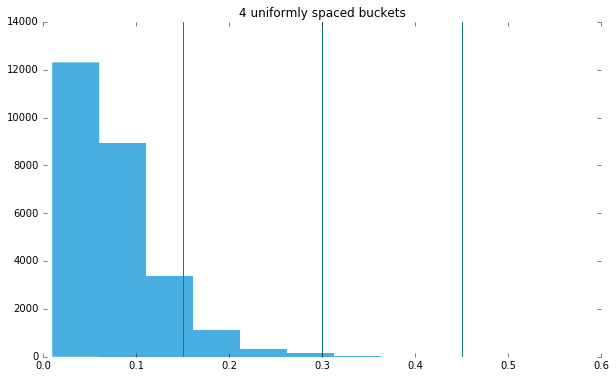

In [98]:
# Visualizae Partition File
%matplotlib inline
import pylab as pl
fig, ax = pl.subplots(figsize=(10,6))

ax.hist(sampleData,color="#48afe0",edgecolor='none')

xcoords = [.15,.3,.45]
for xc in xcoords:
    pl.axvline(x=xc,color="#197f74", linewidth=1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


pl.title("4 uniformly spaced buckets")
pl.show()

<em>Figure 7. Uniform partitions over skewed data.</em>

If we made a uniform partition file the (above example has 4 buckets), we would end up with most of the data in a single reducer, and this would create a bottle neck. To fix this, we must first generate a sample of our data; then, based on this sample, create a partition file that distributes the keys more evenly.


<h2><a name="IV.A">IV.A. Random Sample implementation</a></h2>
<a href="#top">Back to top</a>  | <a href="#Section4">Back to Section 4</a> 


In [87]:
%%writefile MRJob_RandomSample.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

#########################################################
#  Emit a random sample of 1/1000th of the data
#########################################################


import numpy as np
import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRbuildSample(MRJob):
    
    def steps(self):
        return [MRStep(mapper=self.mapper)]
    
    def mapper(self,_,line):
        s = np.random.uniform(0,1)
        if s < .001: 
            yield None, line

    
if __name__ == '__main__':
    MRJob_RandomSample.run()

Overwriting MRJob_RandomSample.py


<h2><a name="IV.B">IV.B. Custom partition file implementation</a></h2>
<a href="#top">Back to top</a>  | <a href="#Section4">Back to Section 4</a> 


<h3>Percentile Based Partitioning</h3>

Once we have a (small) sampled subset of data, we can compute partition boundaries by examining the distribution of this subset, and finding approporiate percentiles based on number of desired partitions. A basic implementation using NumPy is provided below:

In [56]:
def readSampleData():
    # A sample of the data is stored in a single file in sampleData/part-00000
    # from the previous step (MRJob_RandomSample.py)
    sampleData = []  

    with open("sampleData/part-00000","r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            avg,lisst = line.split("\t")
            sampleData.append(float(avg))
            
    return sampleData

In [88]:
from numpy import array, percentile, linspace, random

def partition(data, num_of_partitions=10, return_percentiles=False):
    # remove percentile 100
    qs = linspace(0, 100, num=num_of_partitions, endpoint=False)
    if not return_percentiles:
        return percentile(data, qs)
    return percentile(data, qs), qs

sampleData = readSampleData()

# (partitionFile, percentiles)
partition(sampleData, 4, return_percentiles=True)

(array([ 0.00986008,  0.04131517,  0.06350346,  0.09810477]),
 array([  0.,  25.,  50.,  75.]))

<h3> Raw implementation without using `numpy` </h3>

In [89]:
## MAKE % BASED BUCKETS FROM SAMPLE DATA
from __future__ import division
from math import ceil

sampleData = readSampleData()

num_buckets = 4 # This will be the number of reducers
len_data = len(sampleData)

# make breakpoints:
partitionFile = []

i = 0
while i < len_data:
    partitionFile.append(sampleData[i])
    i += int(ceil(len_data/num_buckets))

<h3> Visualize Partition </h3>

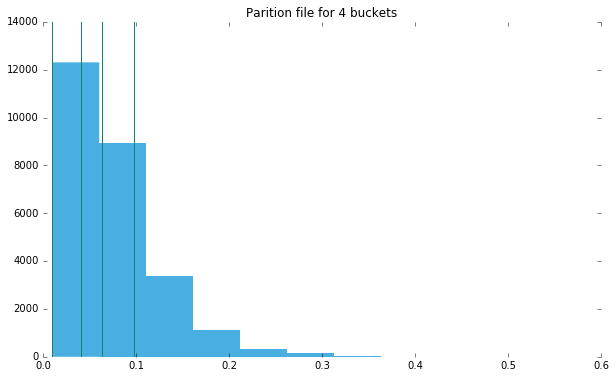

Sample Data min 0.00986007565667
Sample Data max 0.514811335171
[0.009860075656665268, 0.04131516964443623, 0.06350346288221721, 0.0981047679070244]


In [90]:
# Visualizae Partition File
%matplotlib inline
import pylab as pl
fig, ax = pl.subplots(figsize=(10,6))

ax.hist(sampleData,color="#48afe0",edgecolor='none')

xcoords = partitionFile
for xc in xcoords:
    pl.axvline(x=xc,color="#197f74", linewidth=1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


pl.title("Parition file for "+str(num_buckets)+" buckets")
pl.show()

print "Sample Data min", min(sampleData)
print "Sample Data max", max(sampleData)
print partitionFile

<em>Figure 8. Percentile based partitions over skewed data.</em>

We can now replace the dynamilcally generated partition file in our implementation above, (`self.partition_file`) in the `mapper_partitioner_init` function, with the custom file we just made.

<h1><a name="Section5">Section V - Spark implementation</a></h1>
<a href="#top">Back to top</a>   

For this section, you will need to install Spark. We are using a local installation, version 2.0.1

In [1]:
# Start Spark
import os
import sys
spark_home = os.environ['SPARK_HOME'] = \
   '/usr/local/share/spark-2.0.1-bin-hadoop2.6'

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.9-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))
app_name = "total-sort"
    
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
# print sc
# print sqlContext


Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.0.1
      /_/

Using Python version 2.7.11 (default, Dec  6 2015 18:57:58)
SparkSession available as 'spark'.


<h2>SPARK - Key features</h2>

From the Spark website (http://spark.apache.org/):

* Spark is a fast and general engine for large-scale data processing.
* Spark runs on __Hadoop__, Mesos, standalone, or in the cloud.
* Run programs up to __100x faster than Hadoop MapReduce in memory__, or 10x faster on disk.
* Write applications quickly in Java, Scala, __Python__, R.
* Spark offers over 80 high-level operators that make it easy to build parallel apps. And you can use it interactively from the Scala, __Python__ and R shells.
* Apache Spark has an advanced Directed Acyclic Graph (DAG) execution engine that supports cyclic data flow and in-memory computing.




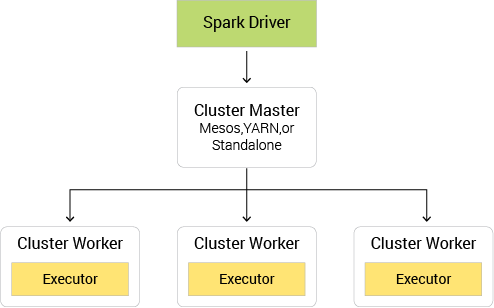

In [11]:
Image('spark-diagram.png')

<em>Figure 9. Spark data flow.</em>

At the core of Spark, are "Resilient Distributed Datasets (RDDs), a distributed memory abstraction that lets programmers perform __in-memory computations on large clusters__ in a fault-tolerant manner." https://www2.eecs.berkeley.edu/Pubs/TechRpts/2011/EECS-2011-82.pdf

An RDD is simply a distributed collection of elements (Key-Value records).
* In Spark all work is expressed as either creating new RDDs, running (lazy) __transformations__ on existing RDDs, or performing __actions__ on RDDs to compute a result.
* Under the hood, Spark automatically distributes the data contained in RDDs across your cluster and parallelizes the operations you perform on them.


<h1> Total Sort in pyspark (Spark python API)</h1>
As before, to acheive Total Order Sort, we must first partition the data such that it ends up in appropriately ordered buckets (partitions, filenames), and then sort within each partition. There are a couple of ways to do this in Spark, but they are not all created equal.



<h2>repartition &amp; sortByKey VS repartitionAndSortWithinPartitions</h2>
https://spark.apache.org/docs/1.6.2/programming-guide.html#working-with-key-value-pairs

<hr>

<h3>__repartition__</h3>
Reshuffle the data in the RDD randomly to create either more or fewer partitions and balance it across them. This always shuffles all data over the network.

<h3>__sortByKey__</h3> 
When called on a dataset of (K, V) pairs where K implements Ordered, returns a dataset of (K, V) pairs sorted by keys in ascending or descending order, as specified in the boolean ascending argument.

__The sortByKey function reshuffles all the data a second time!__

Spark’s sortByKey transformation results in two jobs and three stages.

Sample stage: Sample the data to create a range-partitioner that will result in an even partitioning.   
“Map” stage: Write the data to the destined shuffle bucket for reduce stage.   
“Reduce” stage: Get the related shuffle output and merge/sort on the specific partition of dataset.   


<hr>
<h3>__repartitionAndSortWithinPartitions__</h3>
Repartition the RDD according to the given partitioner and, within each resulting partition, sort records by their keys. <strong><em>This is more efficient than calling repartition and then sorting within each partition because it can push the sorting down into the shuffle machinery.</em></strong>



In [2]:
from operator import itemgetter
import numpy as np

text_file = sc.textFile('generate_numbers.output')
NUM_REDUCERS = 3

# parse input #
def readData(line):
    x = line.split("\t")
    return [int(x[0]),x[1]],""

# Partition function #        
def top_down(x):
    if x[0] > 20:
        return 0
    elif x[0] > 10:
        return 1
    else:
        return 2
    

rdd = text_file.map(readData)


'''
repartitionAndSortWithinPartitions(numPartitions=None, partitionFunc=<function portable_hash at 0x7f2bec385230>, 
ascending=True, keyfunc=<function <lambda> at 0x7f2bec3839b0>) Repartition the RDD according to the given 
partitioner and, within each resulting partition, sort records by their keys.

By using this function we avoid unnecessary shuffling. In contrast, the sortByKey function reshuffles all the data 
and is not efficient.
'''
top = rdd.repartitionAndSortWithinPartitions(numPartitions=NUM_REDUCERS,
                                                    ascending=True, 
                                                    partitionFunc=top_down,
                                                    keyfunc=lambda x: (-x[0],x[1]))

By using glom we can see each partition in its own array. We also have a secondary sort on the "word" (in fact this is the latter part of a complex key) in ascending order.

In [3]:
print top.getNumPartitions(), "Partitions"
for i,d in enumerate(top.glom().collect()):
    print "="*50
    print "partition ",i
    print "="*50
    for j in d:
        print j[0][0],"\t",j[0][1]

3 Partitions
partition  0
30 	do
28 	dataset
27 	creating
27 	driver
27 	experiements
26 	def
26 	descent
25 	compute
24 	code
24 	done
23 	descent
22 	corresponding
partition  1
19 	consists
19 	evaluate
17 	drivers
15 	computational
15 	computing
15 	document
14 	center
13 	efficient
partition  2
10 	clustering
9 	change
9 	during
7 	contour
5 	distributed
4 	develop
3 	different
2 	cluster
1 	cell
0 	current


<h1> Final Remarks</h1>
<a href="#top">Back to top</a>   

A note on TotalSortPartitioner: Hadoop has built in TotalSortPartitioner, which uses a partition file _partition.lst to store a pre-built order list of split points.TotalSortPartitioner uses binary search / Trie to look up the ranges a given record falls into.

https://github.com/facebookarchive/hadoop-20/blob/master/src/mapred/org/apache/hadoop/mapred/lib/TotalOrderPartitioner.java

# References
<a href="#top">Back to top</a>   

<ol>

<li>http://wiki.apache.org/hadoop/</li>
<li>http://hadoop.apache.org/docs/stable1/streaming.html#Hadoop+Streaming</li>
<li>http://mrjob.readthedocs.io/en/latest/index.html</li>
<li>http://www.theunixschool.com/2012/08/linux-sort-command-examples.html</li>
<li>https://hadoop.apache.org/docs/r2.7.2/hadoop-streaming/HadoopStreaming.html</li>
<li>http://hadoop.apache.org/</li>
<li>https://hadoop.apache.org/docs/r2.7.2/hadoop-project-dist/hadoop-common/SingleCluster.html</li>
<li>https://hadoop.apache.org/docs/r1.2.1/streaming.html#Hadoop+Comparator+Class</li>
<li>https://github.com/Yelp/mrjob</li>
<li>https://pythonhosted.org/mrjob/guides/configs-hadoopy-runners.html</li>
<li>http://docs.aws.amazon.com/ElasticMapReduce/latest/DeveloperGuide/emr-steps.html</li>
<li>https://github.com/apache/hadoop/blob/2e1d0ff4e901b8313c8d71869735b94ed8bc40a0/hadoop-mapreduce-project/hadoop-mapreduce-client/hadoop-mapreduce-client-core/src/main/java/org/apache/hadoop/mapreduce/lib/partition/KeyFieldBasedPartitioner.java</li>
<li>http://science.sut.ac.th/mathematics/pairote/uploadfiles/weightedkm-temp2_EB.pdf</li>
<li>http://spark.apache.org/</li>
<li>https://www2.eecs.berkeley.edu/Pubs/TechRpts/2011/EECS-2011-82.pdf</li>
<li>https://spark.apache.org/docs/1.6.2/programming-guide.html#working-with-key-value-pairs </li>
<li>https://github.com/facebookarchive/hadoop-20/blob/master/src/mapred/org/apache/hadoop/mapred/lib/TotalOrderPartitioner.java </li>
</ol>